# Using a predefined random seed and saving the outputs at each step. This is for reproducibility. Simulation without noise

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
#from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
#    ExecutionMode,
#    focusing_optics_factory_method,
#)

from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam

import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_plot_utils as apu
from datetime import datetime
import joblib
import matplotlib as mpl
import cmasher as cm
import colorcet as cc

from epics import ca
ca.finalize_libca()

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
mpl.rcParams.update({'font.size': 16, 'text.usetex':False})

In [5]:
DEFAULT_RANDOM_SEED = 1234 #12345

In [6]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 1e3,
            "sum_intensity_hard_constraint": 1e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["fwhm", "peak_distance", "negative_log_peak_intensity"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm":0.02}
        }

In [7]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

In [8]:
def print_beam_attributes(loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
        "negative_log_peak_intensity": lambda d: -np.log(opt_common._get_peak_intensity_from_dw(d))
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(opt_common._get_weighted_sum_intensity_from_hist(hist, 2))
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In experiments, the perturbed max is about 400 times higher than the noise level. This seems to hold in sim with noise level 0.5

In [9]:
detector_x = 2160 * 0.65 * 1e-3 / 2
detector_y = 2560 * 0.65 * 1e-3 / 2
cp = opt_common.CalculationParameters(
    xrange= [-detector_x / 2, detector_x / 2],
    yrange = [-detector_y / 2, detector_y / 2],
    nbins_h = 1024,
    nbins_v = 1024,
    use_denoised = False,
    random_seed = DEFAULT_RANDOM_SEED,
    add_noise = False,
    calculate_over_noise= False,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=50,
    noise=0.5,
    save_images=True,
    every_n_images=1
   )

xrange_plot = [-0.3, 0.3]
yrange_plot = [-0.3, 0.3]

ppm = opt_common.PlotParameters(xrange=xrange_plot, yrange=yrange_plot, nbins_h = cp.nbins_h // 2, nbins_v = cp.nbins_v // 2)


In [10]:
save_dir = Path(Path.home() / "code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/nf_fwhm_pl_pi")

In [11]:
!rm -r $save_dir

In [12]:
save_dir.mkdir()

In [13]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.35100000000000003, 0.35100000000000003], yrange=[-0.41600000000000004, 0.41600000000000004], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=1234, add_noise=False, noise=0.5, percentage_fluctuation=50, calculate_over_noise=False, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=True, every_n_images=1, rng=Generator(PCG64) at 0x7FC321228040)


In [14]:
ppm

PlotParameters(implementor=0, title='X,Z', xrange=[-0.3, 0.3], yrange=[-0.3, 0.3], nbins_h=512, nbins_v=512, plot_mode=0, aspect_ratio=0, color_map=<matplotlib.colors.ListedColormap object at 0x7fc3003e4dc0>)

In [15]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-25, 25], 'hb_2': [-25, 25], 'hb_pitch': [-0.002, 0.002], 'hb_trans': [-0.03, 0.03], 'vb_bender': [-20.0, 20.0], 'vb_pitch': [-0.002, 0.002], 'vb_trans': [-0.03, 0.03]}
Optimization parameters
{'sum_intensity_soft_constraint': 1000.0, 'sum_intensity_hard_constraint': 1000.0, 'loss_parameters': ['fwhm', 'peak_distance', 'negative_log_peak_intensity'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [16]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


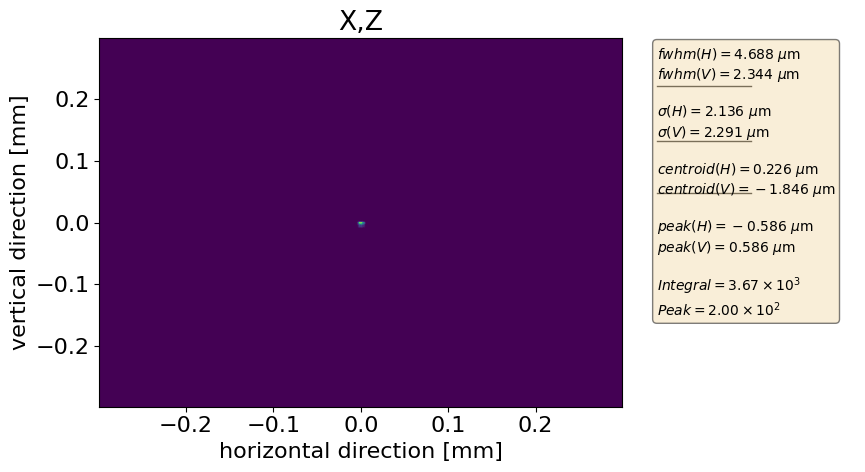

In [17]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp,focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

{'h_sigma': 0.002120446738540371, 'h_fwhm': 0.005484374999999986, 'h_centroid': 0.00022174599618454997, 'h_peak': -0.0010283203124999973, 'v_sigma': 0.0022769246734334276, 'v_fwhm': 0.0024374999999999813, 'v_centroid': -0.0018412399026053036, 'v_peak': 0.0004062499999999969, 'integral_intensity': 3667.060651782501, 'peak_intensity': 92.44429493659787, 'gaussian_fit': {}}


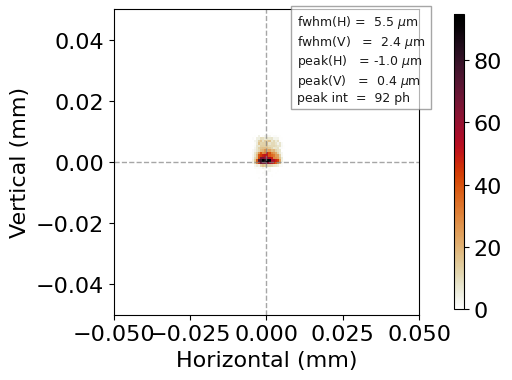

In [18]:
dwd = dict(dw._DictionaryWrapper__dictionary)
print(dwd)
hist = hist
plt.figure(figsize=[5, 5], constrained_layout=True, dpi=100)
ax = plt.gca()

plt.pcolormesh(hist.hh, hist.vv[::-1], hist.data_2D.T, cmap=apu.CMAP, rasterized=True)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Vertical (mm)")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)
# ax.set_yticklabels([])


ax.set_aspect("equal")

text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph"
)
ax.text(
    0.6,
    0.7,
    text,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=ax.transAxes,
)
plt.show()

In [19]:
focused_beam = {'dw': dw, 'hist': hist}
joblib.dump(focused_beam, f'{save_dir}/focused_beam.joblib', compress=5)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/nf_fwhm_pl_pi/focused_beam.joblib']

In [20]:
attribs_focus = print_beam_attributes(opt_params.params['loss_parameters'], hist, dw, "Focused beam")

Focused beam system fwhm: 6.002e-03
Focused beam system peak_distance: 1.106e-03
Focused beam system negative_log_peak_intensity: -4.527e+00


In [21]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [22]:
init_motors_ranges = {k: np.array(v) / 2 for k,v in opt_params.move_motors_ranges.items()}

In [23]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=init_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp,
    
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-156.1, -164.0, 0.17273733853924986, -0.0142, 415.4, 0.17112733853924986, -0.0077]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [11.917494167453555, -2.995106624509555, 0.0008464924675279108, -0.007149227284093673, -3.6180588317160485, -0.0007638175340667144, -0.007747011202416447]


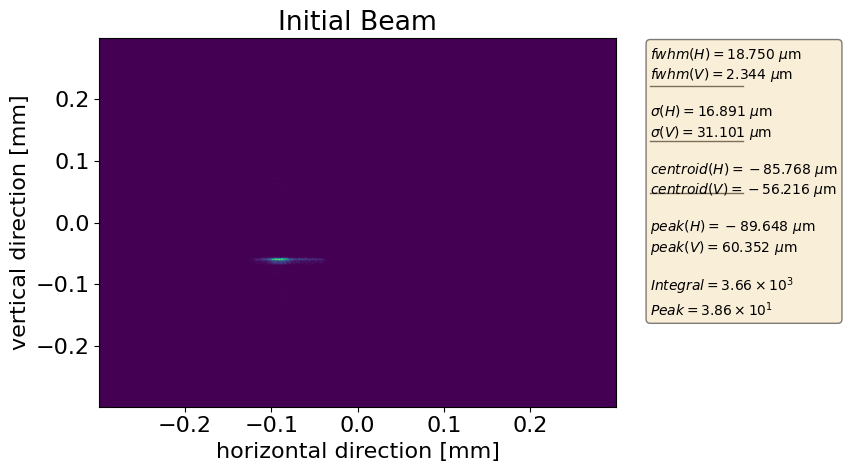

Perturbed beam system fwhm: 1.935e-02
Perturbed beam system peak_distance: 1.116e-01
Perturbed beam system negative_log_peak_intensity: -2.982e+00


In [24]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

In [25]:
{k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}

{'hb_1': -156.1,
 'hb_2': -164.0,
 'hb_pitch': 0.17273733853924986,
 'hb_trans': -0.0142,
 'vb_bender': 415.4,
 'vb_pitch': 0.17112733853924986,
 'vb_trans': -0.0077}

In [26]:
hist_pert.data_2D.max()

19.774808983647983

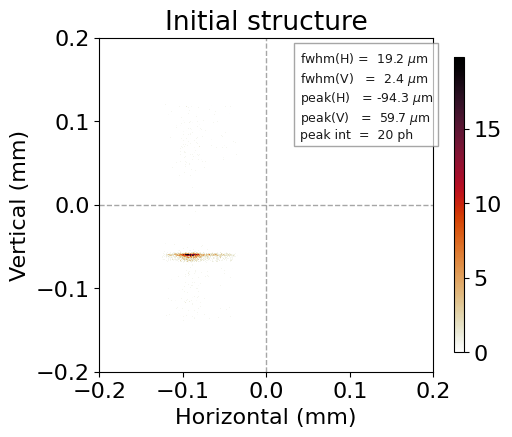

In [27]:
dwd = dw_pert._DictionaryWrapper__dictionary
plt.figure(figsize=[5,5], constrained_layout=True, dpi=100)
plt.pcolormesh(hist_pert.hh, hist_pert.vv, hist_pert.data_2D.T, cmap=apu.CMAP)#, norm=mpl.colors.LogNorm(1, 4e2))
plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title("Initial structure")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph"
)
ax.text(
    0.6,
    0.7,
    text,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=ax.transAxes,
)
plt.show()

In [28]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### Calculating without removing noise

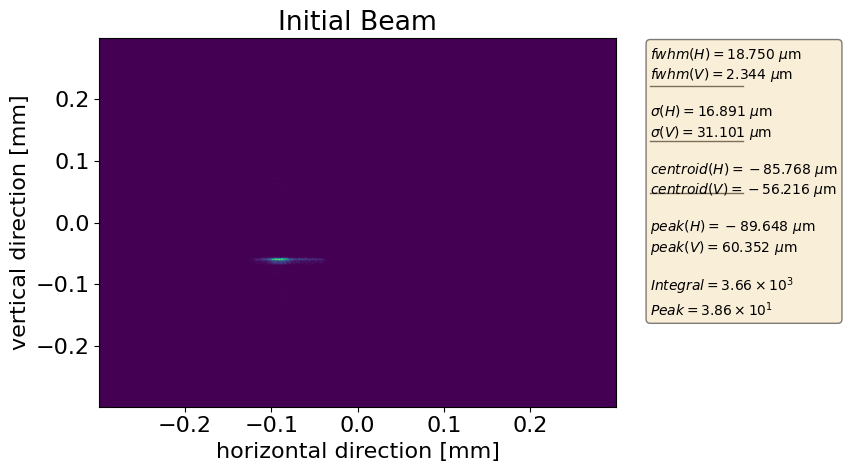

In [29]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [30]:
hist_pert.data_2D.max()

19.774808983647983

In [31]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 1.935e-02
Perturbed beam system peak_distance: 1.116e-01
Perturbed beam system negative_log_peak_intensity: -2.982e+00


In [32]:
opt_params = OptimizationParameters()

In [33]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    dump_directory=save_dir
    )

In [34]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [35]:
attribs_init

{'fwhm': 0.019349455501968378,
 'peak_distance': 0.11158756574609786,
 'negative_log_peak_intensity': -2.9824323543856006}

In [36]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}#, "peak_distance": attribs_init["peak_distance"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-08-10 23:20:11,375] A new study created in memory with name: no-name-ff9a0ed0-502e-4355-9f53-2fe94083c2d9


In [37]:
for i in range(15):
    opt_trial.trials(10)
    joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-08-10 23:20:22,243] Trial 0 finished with values: [0.019349455501968378, 0.11158756574609786, -2.9824323543856006] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:20:33,222] Trial 1 finished with values: [0.0314602856432344, 0.07531431305788379, -2.056235237559521] and parameters: {'hb_1': -16.0, 'hb_2': 6.0, 'hb_pitch': -0.00025, 'hb_trans': 0.017100000000000004, 'vb_bender': 11.0, 'vb_pitch': -0.00092, 'vb_trans': -0.013499999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:20:44,391] Trial 2 finished with values: [0.12547875530782002, 0.26850257147902, -2.1546358063668323] and parameters: {'hb_1': 15.0, 'hb_2': 23.0, 'hb_pitch': 0.0015, 'hb_trans': -0.008599999999999997, 'vb_bender': 0.0, 'vb_pitch': 0.0007200000000000002, 'vb_trans': 0.012700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:20:55,304] Trial 3 finished with values: [0.2632937356857778, 0.11638948465957039, -1.0879393345860398] and parameters: {'hb_1': -7.0, 'hb_2': 3.0, 'hb_pitch': 1.0000000000000026e-05, 'hb_trans': -0.0292, 'vb_bender': 11.0, 'vb_pitch': 0.00152, 'vb_trans': -0.008199999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:21:06,272] Trial 4 finished with values: [0.10286091608211022, 0.057081898737605934, -1.8137209128707386] and parameters: {'hb_1': 6.0, 'hb_2': -22.0, 'hb_pitch': -0.0005299999999999999, 'hb_trans': 0.025900000000000006, 'vb_bender': 6.0, 'vb_pitch': -0.00042, 'vb_trans': 0.017300000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:21:17,245] Trial 5 finished with values: [0.02045282219997029, 0.25148969466291177, -2.106331538276302] and parameters: {'hb_1': -9.0, 'hb_2': 3.0, 'hb_pitch': 0.0014700000000000004, 'hb_trans': -0.0038999999999999972, 'vb_bender': 12.0, 'vb_pitch': -0.0014399999999999999, 'vb_trans': 0.012200000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:21:28,200] Trial 6 finished with values: [0.09965276905965052, 0.2606881599299022, -1.2653944871086278] and parameters: {'hb_1': 10.0, 'hb_2': -14.0, 'hb_pitch': 0.00169, 'hb_trans': -0.003499999999999996, 'vb_bender': 17.0, 'vb_pitch': -0.0017800000000000001, 'vb_trans': -0.018999999999999996}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:21:39,301] Trial 7 finished with values: [0.06643654869453523, 0.14491541291093585, -1.6047214357313324] and parameters: {'hb_1': -23.0, 'hb_2': 9.0, 'hb_pitch': 0.0003700000000000001, 'hb_trans': 0.0019000000000000059, 'vb_bender': -19.0, 'vb_pitch': 0.0002400000000000002, 'vb_trans': -0.010299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:21:50,464] Trial 8 finished with values: [0.09328924740960716, 0.1555647897486685, -0.9915132024194118] and parameters: {'hb_1': 0.0, 'hb_2': -20.0, 'hb_pitch': 0.00042000000000000023, 'hb_trans': 0.0039000000000000007, 'vb_bender': -20.0, 'vb_pitch': 0.00046000000000000034, 'vb_trans': 0.024700000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:22:01,620] Trial 9 finished with values: [0.12298158053360321, 0.2713696646023117, -1.3324191043848166] and parameters: {'hb_1': 15.0, 'hb_2': 25.0, 'hb_pitch': 0.0018300000000000005, 'hb_trans': 0.0175, 'vb_bender': -9.0, 'vb_pitch': 0.00047999999999999996, 'vb_trans': -0.0013999999999999985}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:22:16,821] Trial 10 finished with values: [0.022176934103928733, 0.06139898468600861, -2.982529818647735] and parameters: {'hb_1': -7.0, 'hb_2': 0.0, 'hb_pitch': -0.00031999999999999997, 'hb_trans': 0.007800000000000001, 'vb_bender': 4.0, 'vb_pitch': -0.0005399999999999999, 'vb_trans': -0.001799999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:22:32,946] Trial 11 finished with values: [0.014300129837833816, 0.06009667683107962, -3.079167004238324] and parameters: {'hb_1': -8.0, 'hb_2': 5.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.0023000000000000034, 'vb_bender': 4.0, 'vb_pitch': -0.0007999999999999999, 'vb_trans': -0.0007999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:22:48,360] Trial 12 finished with values: [0.025011814835146466, 0.03439615638961665, -2.787923877767474] and parameters: {'hb_1': -2.0, 'hb_2': 0.0, 'hb_pitch': -0.0006199999999999999, 'hb_trans': 0.0023999999999999994, 'vb_bender': 5.0, 'vb_pitch': -0.00092, 'vb_trans': 0.004700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:23:02,848] Trial 13 finished with values: [0.018281320529377785, 0.029189637736875437, -3.02729811138352] and parameters: {'hb_1': -4.0, 'hb_2': 6.0, 'hb_pitch': -0.0006799999999999998, 'hb_trans': 0.003700000000000002, 'vb_bender': 2.0, 'vb_pitch': -0.00043999999999999985, 'vb_trans': 0.00010000000000000286}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:23:17,273] Trial 14 finished with values: [0.03162921886423863, 0.04021726123867227, -2.5945081848000853] and parameters: {'hb_1': -7.0, 'hb_2': 15.0, 'hb_pitch': -0.00065, 'hb_trans': 0.00040000000000000105, 'vb_bender': 6.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': 0.0075}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:23:31,978] Trial 15 finished with values: [0.04764342909155254, 0.03930365619735701, -2.0363828500583168] and parameters: {'hb_1': -1.0, 'hb_2': -5.0, 'hb_pitch': -0.0005499999999999999, 'hb_trans': -0.003799999999999998, 'vb_bender': -5.0, 'vb_pitch': -0.00114, 'vb_trans': -0.009099999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:23:40,397] Trial 16 finished with values: [0.03723135836311558, 0.02365485592643615, -2.488832726525621] and parameters: {'hb_1': -13.0, 'hb_2': 6.0, 'hb_pitch': -0.00082, 'hb_trans': -0.008399999999999998, 'vb_bender': 9.0, 'vb_pitch': -0.00192, 'vb_trans': 0.016100000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:23:52,051] Trial 17 finished with values: [0.013644218819112978, 0.012023104399689092, -3.414804544184881] and parameters: {'hb_1': -13.0, 'hb_2': 5.0, 'hb_pitch': -0.00083, 'hb_trans': 0.0033000000000000043, 'vb_bender': 2.0, 'vb_pitch': -0.0008599999999999999, 'vb_trans': 0.004300000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:24:09,210] Trial 18 finished with values: [0.029878897376800308, 0.025966706178298018, -2.6288869746909898] and parameters: {'hb_1': -24.0, 'hb_2': 11.0, 'hb_pitch': -0.0012799999999999999, 'hb_trans': 0.015200000000000005, 'vb_bender': 1.0, 'vb_pitch': -0.00076, 'vb_trans': -0.004899999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:24:26,317] Trial 19 finished with values: [0.00858007790270029, 0.030215977238783612, -3.5147440333895457] and parameters: {'hb_1': -9.0, 'hb_2': 4.0, 'hb_pitch': -0.00112, 'hb_trans': 0.009300000000000003, 'vb_bender': 6.0, 'vb_pitch': -0.00074, 'vb_trans': 0.013400000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:24:38,410] Trial 20 finished with values: [0.007968773935319414, 0.017552622803982555, -4.034713668046775] and parameters: {'hb_1': -15.0, 'hb_2': 5.0, 'hb_pitch': -0.0008699999999999999, 'hb_trans': 0.007600000000000003, 'vb_bender': 4.0, 'vb_pitch': -0.00082, 'vb_trans': 0.0119}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:24:51,927] Trial 21 finished with values: [0.013907782926614747, 0.047532485945845054, -3.0638099780587633] and parameters: {'hb_1': -17.0, 'hb_2': 7.0, 'hb_pitch': -0.0009, 'hb_trans': 0.007900000000000004, 'vb_bender': 3.0, 'vb_pitch': -0.00124, 'vb_trans': 0.010100000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:25:08,207] Trial 22 finished with values: [0.02002972730065298, 0.057748833194521586, -3.1056672135004613] and parameters: {'hb_1': -19.0, 'hb_2': -4.0, 'hb_pitch': -0.00134, 'hb_trans': 0.00030000000000000165, 'vb_bender': 4.0, 'vb_pitch': -0.00042, 'vb_trans': 0.007000000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:25:23,987] Trial 23 finished with values: [0.010784561488999405, 0.012709833979989255, -3.3788344298484234] and parameters: {'hb_1': -10.0, 'hb_2': 12.0, 'hb_pitch': -0.001, 'hb_trans': 0.018500000000000003, 'vb_bender': -1.0, 'vb_pitch': -0.00056, 'vb_trans': 0.002800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:25:41,620] Trial 24 finished with values: [0.04346791945760265, 0.08194156286320402, -1.6514265452993493] and parameters: {'hb_1': -21.0, 'hb_2': 0.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.019100000000000006, 'vb_bender': 17.0, 'vb_pitch': -0.0012799999999999999, 'vb_trans': 0.025200000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:25:58,851] Trial 25 finished with values: [0.02029168489156391, 0.016687962929237337, -3.0576191895098117] and parameters: {'hb_1': -7.0, 'hb_2': 16.0, 'hb_pitch': -0.00112, 'hb_trans': 0.028000000000000004, 'vb_bender': 3.0, 'vb_pitch': -0.0005399999999999999, 'vb_trans': 0.0006000000000000033}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:26:15,850] Trial 26 finished with values: [0.016947248405438074, 0.06686520822445678, -3.127357790133925] and parameters: {'hb_1': -9.0, 'hb_2': 12.0, 'hb_pitch': -0.00159, 'hb_trans': 0.019000000000000003, 'vb_bender': -1.0, 'vb_pitch': -0.0008799999999999999, 'vb_trans': 0.0126}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:26:32,016] Trial 27 finished with values: [0.019951038033386014, 0.03742518050023484, -2.227159493445033] and parameters: {'hb_1': -8.0, 'hb_2': 19.0, 'hb_pitch': -0.00098, 'hb_trans': 0.023700000000000006, 'vb_bender': -9.0, 'vb_pitch': -0.00114, 'vb_trans': -0.0014999999999999979}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:26:48,131] Trial 28 finished with values: [0.006840641517671463, 0.024837901164685046, -3.197162893015684] and parameters: {'hb_1': -12.0, 'hb_2': 22.0, 'hb_pitch': -0.00107, 'hb_trans': 0.0075, 'vb_bender': 1.0, 'vb_pitch': -0.00098, 'vb_trans': -0.004399999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:27:04,474] Trial 29 finished with values: [0.008504608700029895, 0.04916137933372792, -2.5802384210466967] and parameters: {'hb_1': -12.0, 'hb_2': 13.0, 'hb_pitch': -0.0009699999999999999, 'hb_trans': -0.000499999999999997, 'vb_bender': -7.0, 'vb_pitch': -0.0003799999999999999, 'vb_trans': -0.018099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:27:17,553] Trial 30 finished with values: [0.045362666363803816, 0.01703493816793343, -2.1192764539880087] and parameters: {'hb_1': -20.0, 'hb_2': 13.0, 'hb_pitch': -0.00081, 'hb_trans': 0.020200000000000003, 'vb_bender': 8.0, 'vb_pitch': -0.0005199999999999998, 'vb_trans': 0.018800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:27:32,886] Trial 31 finished with values: [0.025011814835146466, 0.027087242480129038, -2.662356690653533] and parameters: {'hb_1': -15.0, 'hb_2': 12.0, 'hb_pitch': -0.0009399999999999999, 'hb_trans': 0.0014000000000000054, 'vb_bender': 8.0, 'vb_pitch': -0.00074, 'vb_trans': 0.021400000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:27:47,894] Trial 32 finished with values: [0.007387275694977349, 0.0037207663062630795, -3.74630824710183] and parameters: {'hb_1': -11.0, 'hb_2': 10.0, 'hb_pitch': -0.0008699999999999999, 'hb_trans': 0.010700000000000001, 'vb_bender': 3.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': 0.0063}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:28:05,659] Trial 33 finished with values: [0.01609903785721299, 0.03415068558916529, -3.0878937117993432] and parameters: {'hb_1': -15.0, 'hb_2': 18.0, 'hb_pitch': -0.00123, 'hb_trans': 0.018300000000000004, 'vb_bender': -2.0, 'vb_pitch': -0.00058, 'vb_trans': -0.018799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:28:24,314] Trial 34 finished with values: [0.045220553432690054, 0.02959726084394328, -1.857921762282351] and parameters: {'hb_1': -5.0, 'hb_2': 24.0, 'hb_pitch': -0.0006399999999999999, 'hb_trans': 0.00020000000000000226, 'vb_bender': 11.0, 'vb_pitch': -0.00092, 'vb_trans': 0.006600000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:28:41,374] Trial 35 finished with values: [0.040577626797772416, 0.003111594936427431, -2.6465209787014867] and parameters: {'hb_1': -19.0, 'hb_2': 11.0, 'hb_pitch': -0.00073, 'hb_trans': 0.0033000000000000043, 'vb_bender': 4.0, 'vb_pitch': -0.00074, 'vb_trans': 0.00040000000000000105}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:28:55,215] Trial 36 finished with values: [0.009174978845556302, 0.009334784809282293, -3.5381387963862463] and parameters: {'hb_1': -10.0, 'hb_2': 16.0, 'hb_pitch': -0.00084, 'hb_trans': 0.013700000000000004, 'vb_bender': 0.0, 'vb_pitch': -0.0007799999999999999, 'vb_trans': -0.001799999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:29:11,745] Trial 37 finished with values: [0.009174978845556302, 0.008472568509749846, -3.7128230155145148] and parameters: {'hb_1': -11.0, 'hb_2': 6.0, 'hb_pitch': -0.00082, 'hb_trans': 0.009800000000000003, 'vb_bender': 2.0, 'vb_pitch': -0.00066, 'vb_trans': 0.012500000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:29:33,364] Trial 38 finished with values: [0.018281320529377785, 0.014710186291363666, -2.4737770071726173] and parameters: {'hb_1': -17.0, 'hb_2': 25.0, 'hb_pitch': -0.00098, 'hb_trans': 0.007600000000000003, 'vb_bender': -6.0, 'vb_pitch': -0.0003799999999999999, 'vb_trans': 0.0109}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:29:44,176] Trial 39 finished with values: [0.012098972503920896, 0.0026576902187593426, -3.538824718718781] and parameters: {'hb_1': -13.0, 'hb_2': 5.0, 'hb_pitch': -0.0008699999999999999, 'hb_trans': 0.011700000000000002, 'vb_bender': 4.0, 'vb_pitch': -0.0006199999999999999, 'vb_trans': 0.008200000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:30:05,748] Trial 40 finished with values: [0.01013299094508445, 0.08556960167960076, -2.7503341909632706] and parameters: {'hb_1': -13.0, 'hb_2': -6.0, 'hb_pitch': -0.00049, 'hb_trans': 0.0138, 'vb_bender': 2.0, 'vb_pitch': 6.000000000000016e-05, 'vb_trans': 0.021700000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:30:25,035] Trial 41 finished with values: [0.03500063350649109, 0.08540847792722213, -2.6602112564706033] and parameters: {'hb_1': -18.0, 'hb_2': 8.0, 'hb_pitch': -0.0015, 'hb_trans': 0.016900000000000005, 'vb_bender': -5.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': 0.0017000000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:30:46,425] Trial 42 finished with values: [0.013424727220090428, 0.04438966983571836, -3.4398307576814204] and parameters: {'hb_1': -12.0, 'hb_2': 6.0, 'hb_pitch': -0.0013, 'hb_trans': 0.012900000000000002, 'vb_bender': 6.0, 'vb_pitch': -0.00042, 'vb_trans': 0.0007000000000000027}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:31:08,611] Trial 43 finished with values: [0.07636912481557981, 0.027785027760959802, -1.2701719132730356] and parameters: {'hb_1': -18.0, 'hb_2': 12.0, 'hb_pitch': -0.00049, 'hb_trans': -0.009799999999999996, 'vb_bender': -15.0, 'vb_pitch': -0.00168, 'vb_trans': -0.000899999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:31:28,558] Trial 44 finished with values: [0.014601375572514322, 0.03035907935657743, -2.976075129091938] and parameters: {'hb_1': -16.0, 'hb_2': 12.0, 'hb_pitch': -0.00119, 'hb_trans': 0.004800000000000006, 'vb_bender': -2.0, 'vb_pitch': -0.00047999999999999996, 'vb_trans': 0.011600000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:31:50,387] Trial 45 finished with values: [0.03055546254770006, 0.025183535602278182, -3.1049932093461896] and parameters: {'hb_1': -15.0, 'hb_2': 6.0, 'hb_pitch': -0.00113, 'hb_trans': 0.018000000000000002, 'vb_bender': 0.0, 'vb_pitch': -0.0009599999999999999, 'vb_trans': -0.019999999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:32:14,856] Trial 46 finished with values: [0.014551818859816285, 0.055296177696106424, -2.67136569495823] and parameters: {'hb_1': -14.0, 'hb_2': 22.0, 'hb_pitch': -0.0005399999999999999, 'hb_trans': 0.017300000000000003, 'vb_bender': 3.0, 'vb_pitch': -0.00112, 'vb_trans': -0.003499999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:32:36,032] Trial 47 finished with values: [0.023534082574057057, 0.03372777556075154, -2.232478604504535] and parameters: {'hb_1': -8.0, 'hb_2': 17.0, 'hb_pitch': -0.00067, 'hb_trans': 0.007300000000000001, 'vb_bender': -5.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': 0.008400000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:32:58,583] Trial 48 finished with values: [0.03724177224864197, 0.027005054442293064, -3.0261971300945647] and parameters: {'hb_1': -11.0, 'hb_2': 1.0, 'hb_pitch': -0.00104, 'hb_trans': 0.023000000000000007, 'vb_bender': -1.0, 'vb_pitch': -0.00076, 'vb_trans': 0.008700000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:33:22,356] Trial 49 finished with values: [0.01805773324337565, 0.07683640379228468, -2.687369408353704] and parameters: {'hb_1': -7.0, 'hb_2': 18.0, 'hb_pitch': -0.0015300000000000001, 'hb_trans': 0.014100000000000001, 'vb_bender': 4.0, 'vb_pitch': -0.00172, 'vb_trans': -0.004099999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:33:45,477] Trial 50 finished with values: [0.022984911489027846, 0.010614442898635819, -3.0310271804516375] and parameters: {'hb_1': -6.0, 'hb_2': 21.0, 'hb_pitch': -0.00101, 'hb_trans': 0.0238, 'vb_bender': 1.0, 'vb_pitch': -0.0006199999999999999, 'vb_trans': 0.0005000000000000039}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:34:08,246] Trial 51 finished with values: [0.029878897376800308, 0.01892717824214752, -3.0054178395958546] and parameters: {'hb_1': -9.0, 'hb_2': 8.0, 'hb_pitch': -0.0012599999999999998, 'hb_trans': 0.0233, 'vb_bender': 2.0, 'vb_pitch': -0.0006999999999999999, 'vb_trans': -0.005799999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:34:29,241] Trial 52 finished with values: [0.03519811965298297, 0.01789958476964877, -2.878602459383678] and parameters: {'hb_1': -15.0, 'hb_2': -3.0, 'hb_pitch': -0.00081, 'hb_trans': -0.007999999999999997, 'vb_bender': 1.0, 'vb_pitch': -0.00056, 'vb_trans': 0.006000000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:34:52,458] Trial 53 finished with values: [0.01013299094508445, 0.04345178190951858, -3.0881307603182018] and parameters: {'hb_1': -13.0, 'hb_2': 16.0, 'hb_pitch': -0.00056, 'hb_trans': 0.010700000000000001, 'vb_bender': -1.0, 'vb_pitch': -0.00074, 'vb_trans': 0.020100000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:35:12,439] Trial 54 finished with values: [0.007387275694977349, 0.02986436472611948, -3.0375033864319736] and parameters: {'hb_1': -12.0, 'hb_2': -4.0, 'hb_pitch': -0.0007199999999999999, 'hb_trans': 0.014400000000000003, 'vb_bender': 8.0, 'vb_pitch': -0.0006999999999999999, 'vb_trans': 0.014400000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:35:31,500] Trial 55 finished with values: [0.012632824729672842, 0.01296609127873166, -3.270812788803177] and parameters: {'hb_1': -18.0, 'hb_2': 7.0, 'hb_pitch': -0.0008699999999999999, 'hb_trans': 0.001800000000000003, 'vb_bender': -1.0, 'vb_pitch': -0.00108, 'vb_trans': -0.015399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:35:52,288] Trial 56 finished with values: [0.010784561488999405, 0.056938578464582744, -2.735801488413052] and parameters: {'hb_1': -9.0, 'hb_2': 15.0, 'hb_pitch': -0.0012599999999999998, 'hb_trans': 0.0019000000000000059, 'vb_bender': -3.0, 'vb_pitch': -0.0006199999999999999, 'vb_trans': -0.002599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:36:07,301] Trial 57 finished with values: [0.02448437071546402, 0.026371097818407362, -2.5712793023432035] and parameters: {'hb_1': -8.0, 'hb_2': 12.0, 'hb_pitch': -0.00056, 'hb_trans': 0.006000000000000005, 'vb_bender': -2.0, 'vb_pitch': -0.0009599999999999999, 'vb_trans': -0.029099999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:36:25,600] Trial 58 finished with values: [0.010572291604092367, 0.019187489686646308, -2.760063146583707] and parameters: {'hb_1': -13.0, 'hb_2': -12.0, 'hb_pitch': -0.00082, 'hb_trans': 0.008800000000000002, 'vb_bender': 9.0, 'vb_pitch': -0.00082, 'vb_trans': 0.009500000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:36:49,769] Trial 59 finished with values: [0.011380241276440885, 0.07878990470803003, -2.90927978649824] and parameters: {'hb_1': -14.0, 'hb_2': -12.0, 'hb_pitch': -0.0011099999999999999, 'hb_trans': 0.008300000000000002, 'vb_bender': 2.0, 'vb_pitch': -0.0014, 'vb_trans': -0.014399999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:37:08,539] Trial 60 finished with values: [0.07137091063427452, 0.06466033737515835, -2.3980012238106485] and parameters: {'hb_1': -23.0, 'hb_2': -14.0, 'hb_pitch': -0.00076, 'hb_trans': -0.0002999999999999982, 'vb_bender': 3.0, 'vb_pitch': -0.00027999999999999987, 'vb_trans': -0.0266}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:37:27,806] Trial 61 finished with values: [0.013424727220090428, 0.0030239637444255127, -3.3786730376827063] and parameters: {'hb_1': -13.0, 'hb_2': 0.0, 'hb_pitch': -0.0009, 'hb_trans': 0.007900000000000004, 'vb_bender': 4.0, 'vb_pitch': -0.00058, 'vb_trans': 0.016900000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:37:47,717] Trial 62 finished with values: [0.009174978845556302, 0.035565498225662656, -2.8888387238314173] and parameters: {'hb_1': -11.0, 'hb_2': -7.0, 'hb_pitch': -0.00067, 'hb_trans': 0.0032000000000000015, 'vb_bender': 8.0, 'vb_pitch': -0.0008799999999999999, 'vb_trans': 0.0211}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:38:04,530] Trial 63 finished with values: [0.009447086946896683, 0.005286145802046184, -3.0153482685373656] and parameters: {'hb_1': -13.0, 'hb_2': -10.0, 'hb_pitch': -0.00082, 'hb_trans': 0.0063, 'vb_bender': 4.0, 'vb_pitch': -0.00192, 'vb_trans': 0.0216}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-p

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:38:21,309] Trial 64 finished with values: [0.008565677025576764, 0.028894623285291143, -3.4162921346125406] and parameters: {'hb_1': -10.0, 'hb_2': 12.0, 'hb_pitch': -0.00089, 'hb_trans': 0.011300000000000004, 'vb_bender': 4.0, 'vb_pitch': -0.00084, 'vb_trans': 0.0228}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:38:46,160] Trial 65 finished with values: [0.016771041180130213, 0.04499327826630856, -3.2966151341135617] and parameters: {'hb_1': -5.0, 'hb_2': 8.0, 'hb_pitch': -0.00135, 'hb_trans': 0.013200000000000003, 'vb_bender': 3.0, 'vb_pitch': -0.0004599999999999999, 'vb_trans': 0.021500000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:39:06,088] Trial 66 finished with values: [0.007925170213092823, 0.03393700195003248, -3.163725444015418] and parameters: {'hb_1': -11.0, 'hb_2': -13.0, 'hb_pitch': -0.00107, 'hb_trans': 0.0020000000000000018, 'vb_bender': -3.0, 'vb_pitch': -0.0005, 'vb_trans': 0.016800000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:39:23,947] Trial 67 finished with values: [0.016761986045155174, 0.014671612949488958, -2.45100335969723] and parameters: {'hb_1': -9.0, 'hb_2': -25.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': 0.0131, 'vb_bender': 5.0, 'vb_pitch': -0.00182, 'vb_trans': 0.018800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:39:42,494] Trial 68 finished with values: [0.009902343749999971, 0.026401906991487766, -3.351322173921298] and parameters: {'hb_1': -13.0, 'hb_2': -10.0, 'hb_pitch': -0.00082, 'hb_trans': -0.0011999999999999962, 'vb_bender': 4.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': 0.0077000000000000055}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:40:08,185] Trial 69 finished with values: [0.02636564260520399, 0.028171516318849194, -3.1235093333186494] and parameters: {'hb_1': -9.0, 'hb_2': -1.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': 0.0143, 'vb_bender': 2.0, 'vb_pitch': -0.0004599999999999999, 'vb_trans': 0.0023999999999999994}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:40:25,368] Trial 70 finished with values: [0.011263940608518189, 0.021987522596702218, -2.52371995411275] and parameters: {'hb_1': -11.0, 'hb_2': -18.0, 'hb_pitch': -0.0007799999999999999, 'hb_trans': 0.0006000000000000033, 'vb_bender': 10.0, 'vb_pitch': -0.0017000000000000001, 'vb_trans': 0.011100000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:40:44,993] Trial 71 finished with values: [0.011056589562790552, 0.023824312439130895, -3.477668404943577] and parameters: {'hb_1': -10.0, 'hb_2': 15.0, 'hb_pitch': -0.00112, 'hb_trans': 0.013300000000000006, 'vb_bender': 0.0, 'vb_pitch': -0.0006999999999999999, 'vb_trans': -0.008599999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:41:05,751] Trial 72 finished with values: [0.010764786597660133, 0.05329749383849504, -3.2696481335131966] and parameters: {'hb_1': -13.0, 'hb_2': -9.0, 'hb_pitch': -0.0007199999999999999, 'hb_trans': 0.006100000000000001, 'vb_bender': 3.0, 'vb_pitch': -0.00112, 'vb_trans': 0.0233}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:41:23,522] Trial 73 finished with values: [0.010784561488999405, 0.019435428840218226, -3.3213431706996386] and parameters: {'hb_1': -11.0, 'hb_2': 8.0, 'hb_pitch': -0.0007899999999999999, 'hb_trans': 0.013900000000000003, 'vb_bender': -2.0, 'vb_pitch': -0.0005999999999999998, 'vb_trans': 0.004500000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:41:45,507] Trial 74 finished with values: [0.013587472171983013, 0.03178770624259621, -3.1946131066309364] and parameters: {'hb_1': -7.0, 'hb_2': 4.0, 'hb_pitch': -0.0010199999999999999, 'hb_trans': 0.007000000000000006, 'vb_bender': 1.0, 'vb_pitch': -0.00184, 'vb_trans': 0.0013000000000000025}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:42:08,642] Trial 75 finished with values: [0.007586827517627256, 0.022030171794074342, -3.8076471114338153] and parameters: {'hb_1': -10.0, 'hb_2': 2.0, 'hb_pitch': -0.001, 'hb_trans': 0.0077000000000000055, 'vb_bender': 0.0, 'vb_pitch': -0.00066, 'vb_trans': -0.006299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:42:32,202] Trial 76 finished with values: [0.013344385922575584, 0.020173906148685236, -2.7549211448874678] and parameters: {'hb_1': -15.0, 'hb_2': 14.0, 'hb_pitch': -0.00099, 'hb_trans': 0.007800000000000001, 'vb_bender': -3.0, 'vb_pitch': -0.0018, 'vb_trans': 0.009000000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:42:54,334] Trial 77 finished with values: [0.02222376006951106, 0.0676080222614921, -3.02044477924106] and parameters: {'hb_1': -13.0, 'hb_2': 4.0, 'hb_pitch': -0.00022999999999999995, 'hb_trans': 0.014700000000000005, 'vb_bender': 4.0, 'vb_pitch': -0.002, 'vb_trans': 0.0040999999999999995}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:43:20,021] Trial 78 finished with values: [0.009447086946896683, 0.024233835259827353, -3.20236898984725] and parameters: {'hb_1': -12.0, 'hb_2': -7.0, 'hb_pitch': -0.00101, 'hb_trans': 0.002700000000000001, 'vb_bender': -1.0, 'vb_pitch': -0.0019, 'vb_trans': 0.016600000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:43:43,557] Trial 79 finished with values: [0.006973552605638188, 0.01997989313782458, -4.008959353524327] and parameters: {'hb_1': -13.0, 'hb_2': 1.0, 'hb_pitch': -0.0008599999999999999, 'hb_trans': 0.005600000000000001, 'vb_bender': 5.0, 'vb_pitch': -0.00082, 'vb_trans': -0.0277}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:44:02,531] Trial 80 finished with values: [0.015479225387906772, 0.01787103678376335, -3.0738360728160496] and parameters: {'hb_1': -17.0, 'hb_2': 7.0, 'hb_pitch': -0.00091, 'hb_trans': 0.010700000000000001, 'vb_bender': -1.0, 'vb_pitch': -0.00168, 'vb_trans': 0.020700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:44:23,159] Trial 81 finished with values: [0.010764786597660133, 0.006103382889181677, -3.745372898734625] and parameters: {'hb_1': -13.0, 'hb_2': 4.0, 'hb_pitch': -0.0008799999999999999, 'hb_trans': 0.0040999999999999995, 'vb_bender': 2.0, 'vb_pitch': -0.0008599999999999999, 'vb_trans': -0.015399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:44:45,700] Trial 82 finished with values: [0.018580959299574117, 0.02249466440727577, -3.3096421698421494] and parameters: {'hb_1': -13.0, 'hb_2': 7.0, 'hb_pitch': -0.0009399999999999999, 'hb_trans': 0.015600000000000003, 'vb_bender': 6.0, 'vb_pitch': -0.00011999999999999988, 'vb_trans': 0.0279}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:45:10,265] Trial 83 finished with values: [0.008565677025576764, 0.02469099901729835, -3.78269727390836] and parameters: {'hb_1': -11.0, 'hb_2': 8.0, 'hb_pitch': -0.00101, 'hb_trans': 0.012100000000000007, 'vb_bender': 2.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': 0.008200000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:45:28,510] Trial 84 finished with values: [0.01115628350944718, 0.06705315665424624, -3.4827935501723077] and parameters: {'hb_1': -10.0, 'hb_2': 1.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': 0.0046, 'vb_bender': 4.0, 'vb_pitch': -0.0016, 'vb_trans': -0.0225}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:45:57,848] Trial 85 finished with values: [0.008211541673552761, 0.03113725390373385, -3.295190036263395] and parameters: {'hb_1': -12.0, 'hb_2': 19.0, 'hb_pitch': -0.00119, 'hb_trans': 0.015700000000000006, 'vb_bender': 6.0, 'vb_pitch': -0.0006999999999999999, 'vb_trans': -0.023399999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:46:19,978] Trial 86 finished with values: [0.018792922164805284, 0.015865346812134293, -2.819198627218722] and parameters: {'hb_1': -9.0, 'hb_2': -12.0, 'hb_pitch': -0.00075, 'hb_trans': -0.002199999999999997, 'vb_bender': 5.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': 0.013500000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:46:44,704] Trial 87 finished with values: [0.01445047814129209, 0.04444301086034316, -2.435415159505143] and parameters: {'hb_1': -13.0, 'hb_2': -11.0, 'hb_pitch': -0.0004299999999999998, 'hb_trans': 0.006500000000000006, 'vb_bender': -7.0, 'vb_pitch': -0.00196, 'vb_trans': 0.016600000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:47:04,488] Trial 88 finished with values: [0.015850340426185647, 0.020811241890853406, -2.7773078218719602] and parameters: {'hb_1': -18.0, 'hb_2': -3.0, 'hb_pitch': -0.00091, 'hb_trans': 0.00040000000000000105, 'vb_bender': -5.0, 'vb_pitch': -0.00084, 'vb_trans': -0.0299}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:47:26,430] Trial 89 finished with values: [0.009794365715142672, 0.015865346812134293, -3.5736035583841548] and parameters: {'hb_1': -14.0, 'hb_2': 8.0, 'hb_pitch': -0.0009699999999999999, 'hb_trans': 0.006000000000000005, 'vb_bender': 1.0, 'vb_pitch': -0.0008799999999999999, 'vb_trans': -0.022199999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:47:48,742] Trial 90 finished with values: [0.011591592017197765, 0.032085334736874846, -2.879361548908878] and parameters: {'hb_1': -14.0, 'hb_2': -14.0, 'hb_pitch': -0.00091, 'hb_trans': 0.0011000000000000038, 'vb_bender': -1.0, 'vb_pitch': -0.00184, 'vb_trans': -0.0024999999999999988}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:48:11,292] Trial 91 finished with values: [0.006840641517671463, 0.01236990625375245, -3.314664151456443] and parameters: {'hb_1': -12.0, 'hb_2': 12.0, 'hb_pitch': -0.00084, 'hb_trans': 0.008800000000000002, 'vb_bender': -4.0, 'vb_pitch': -0.0008799999999999999, 'vb_trans': -0.001299999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:48:29,793] Trial 92 finished with values: [0.012003295445938962, 0.017077686998730916, -3.1166827985965497] and parameters: {'hb_1': -15.0, 'hb_2': 16.0, 'hb_pitch': -0.00084, 'hb_trans': 0.0063, 'vb_bender': 2.0, 'vb_pitch': -0.00116, 'vb_trans': -0.016099999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:48:55,758] Trial 93 finished with values: [0.019620497654816355, 0.022283976833417055, -3.0671675842998356] and parameters: {'hb_1': -9.0, 'hb_2': -1.0, 'hb_pitch': -0.00059, 'hb_trans': 0.002600000000000005, 'vb_bender': 4.0, 'vb_pitch': -0.00074, 'vb_trans': 0.0020000000000000018}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:49:10,385] Trial 94 finished with values: [0.007441532612526159, 0.12802993043382935, -3.141207595015738] and parameters: {'hb_1': -12.0, 'hb_2': -9.0, 'hb_pitch': -0.0016, 'hb_trans': -0.014699999999999998, 'vb_bender': 3.0, 'vb_pitch': -0.00156, 'vb_trans': 0.007100000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:49:39,775] Trial 95 finished with values: [0.008412079218732188, 0.017867176424530975, -3.2474859407353924] and parameters: {'hb_1': -12.0, 'hb_2': 1.0, 'hb_pitch': -0.0009599999999999999, 'hb_trans': 0.004300000000000005, 'vb_bender': -6.0, 'vb_pitch': -0.00082, 'vb_trans': -0.004099999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:50:06,572] Trial 96 finished with values: [0.012750038296511062, 0.031668453850423925, -2.785974223190678] and parameters: {'hb_1': -10.0, 'hb_2': -6.0, 'hb_pitch': -0.00101, 'hb_trans': 0.008900000000000005, 'vb_bender': 6.0, 'vb_pitch': -0.002, 'vb_trans': -0.014799999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:50:36,391] Trial 97 finished with values: [0.007968773935319414, 0.002059968492952138, -3.5372802914158212] and parameters: {'hb_1': -12.0, 'hb_2': 15.0, 'hb_pitch': -0.0009499999999999999, 'hb_trans': 0.013000000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.0006399999999999999, 'vb_trans': 0.007800000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 23:50:59,388] Trial 98 finished with values: [0.011380241276440885, 0.021657388258135724, -3.0936491641538537] and parameters: {'hb_1': -11.0, 'hb_2': 9.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': 0.0143, 'vb_bender': -1.0, 'vb_pitch': -0.00106, 'vb_trans': -0.015499999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:00:29,702] Trial 99 finished with values: [0.00884527165023244, 0.026421678232174287, -3.4192321849193386] and parameters: {'hb_1': -13.0, 'hb_2': -8.0, 'hb_pitch': -0.00103, 'hb_trans': 0.0023000000000000034, 'vb_bender': 4.0, 'vb_pitch': -0.0006199999999999999, 'vb_trans': 0.0085}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:01:05,150] Trial 100 finished with values: [0.011440103870267053, 0.012329501617890697, -3.3794866087137843] and parameters: {'hb_1': -17.0, 'hb_2': 0.0, 'hb_pitch': -0.00093, 'hb_trans': 0.002700000000000001, 'vb_bender': 0.0, 'vb_pitch': -0.0005399999999999999, 'vb_trans': 0.014400000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:01:30,005] Trial 101 finished with values: [0.005795796008598883, 0.012741041177516496, -3.9112684249530307] and parameters: {'hb_1': -12.0, 'hb_2': 22.0, 'hb_pitch': -0.0008599999999999999, 'hb_trans': 0.014700000000000005, 'vb_bender': 0.0, 'vb_pitch': -0.00043999999999999985, 'vb_trans': 0.026800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:01:56,478] Trial 102 finished with values: [0.011030670583058939, 0.02205225480243785, -2.9623663996347926] and parameters: {'hb_1': -10.0, 'hb_2': 14.0, 'hb_pitch': -0.0009599999999999999, 'hb_trans': 0.027300000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.002, 'vb_trans': 0.016800000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:02:19,049] Trial 103 finished with values: [0.02704320890459677, 0.015430153554324158, -2.7221099392120527] and parameters: {'hb_1': -16.0, 'hb_2': -9.0, 'hb_pitch': -0.00073, 'hb_trans': 0.011000000000000003, 'vb_bender': 0.0, 'vb_pitch': -0.0008799999999999999, 'vb_trans': -0.011}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:02:45,708] Trial 104 finished with values: [0.008565677025576764, 0.01787103678376335, -3.2814784464574154] and parameters: {'hb_1': -11.0, 'hb_2': 25.0, 'hb_pitch': -0.00104, 'hb_trans': 0.020500000000000004, 'vb_bender': 0.0, 'vb_pitch': -0.001, 'vb_trans': -0.0016999999999999967}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:03:20,710] Trial 105 finished with values: [0.021999844723933723, 0.036161725776156284, -2.492806093820063] and parameters: {'hb_1': -8.0, 'hb_2': 11.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.018500000000000003, 'vb_bender': 3.0, 'vb_pitch': -0.00176, 'vb_trans': 0.0165}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:03:54,431] Trial 106 finished with values: [0.007901014200128004, 0.005252132255248668, -2.6655092555627458] and parameters: {'hb_1': -12.0, 'hb_2': 22.0, 'hb_pitch': -0.00099, 'hb_trans': 0.0126, 'vb_bender': 11.0, 'vb_pitch': -0.0005199999999999998, 'vb_trans': 0.007600000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:04:21,199] Trial 107 finished with values: [0.007714113147763248, 0.10208288150661414, -3.535550427759893] and parameters: {'hb_1': -11.0, 'hb_2': -8.0, 'hb_pitch': -0.00157, 'hb_trans': -0.004899999999999998, 'vb_bender': 4.0, 'vb_pitch': 0.0005600000000000002, 'vb_trans': -0.027899999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:04:42,227] Trial 108 finished with values: [0.008979562442373986, 0.039952584117917585, -3.306682290886922] and parameters: {'hb_1': -11.0, 'hb_2': 25.0, 'hb_pitch': -0.0012599999999999998, 'hb_trans': 0.011800000000000005, 'vb_bender': 2.0, 'vb_pitch': -0.00076, 'vb_trans': 0.016300000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:05:06,745] Trial 109 finished with values: [0.015479225387906772, 0.1479814729209639, -2.5536030577968245] and parameters: {'hb_1': -9.0, 'hb_2': -11.0, 'hb_pitch': -0.00193, 'hb_trans': -0.007599999999999999, 'vb_bender': 11.0, 'vb_pitch': 0.0005600000000000002, 'vb_trans': -0.007399999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:05:29,885] Trial 110 finished with values: [0.03560374078706067, 0.02249466440727577, -2.2183834465821524] and parameters: {'hb_1': -11.0, 'hb_2': 18.0, 'hb_pitch': -0.00119, 'hb_trans': 0.0233, 'vb_bender': 16.0, 'vb_pitch': -0.0007799999999999999, 'vb_trans': 0.008800000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:05:59,054] Trial 111 finished with values: [0.06593559602275476, 0.03781972800285617, -1.2796274215078207] and parameters: {'hb_1': -7.0, 'hb_2': 22.0, 'hb_pitch': -0.00103, 'hb_trans': 0.0143, 'vb_bender': 3.0, 'vb_pitch': 0.0, 'vb_trans': 0.026600000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:06:23,814] Trial 112 finished with values: [0.022176934103928733, 0.029294006516473164, -2.8454708047154207] and parameters: {'hb_1': -15.0, 'hb_2': -9.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.0016999999999999967, 'vb_bender': -1.0, 'vb_pitch': -0.00066, 'vb_trans': -0.0211}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/V

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:06:51,003] Trial 113 finished with values: [0.011056589562790552, 0.009334784809282293, -2.8604718530405577] and parameters: {'hb_1': -14.0, 'hb_2': 15.0, 'hb_pitch': -0.0009599999999999999, 'hb_trans': 0.016600000000000004, 'vb_bender': -5.0, 'vb_pitch': -0.00066, 'vb_trans': 0.001800000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:07:12,217] Trial 114 finished with values: [0.014551818859816285, 0.012104066731253214, -2.5043763379105926] and parameters: {'hb_1': -14.0, 'hb_2': 9.0, 'hb_pitch': -0.0005999999999999998, 'hb_trans': -0.0016999999999999967, 'vb_bender': 9.0, 'vb_pitch': -0.0009399999999999999, 'vb_trans': -0.0272}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:07:38,224] Trial 115 finished with values: [0.6908549727685548, 0.11084443104236023, -0.8690798088397275] and parameters: {'hb_1': -14.0, 'hb_2': -4.0, 'hb_pitch': -0.00056, 'hb_trans': 0.003600000000000006, 'vb_bender': 6.0, 'vb_pitch': -0.0012599999999999998, 'vb_trans': -0.0248}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:08:02,418] Trial 116 finished with values: [0.020020181772967344, 0.024988867627148914, -2.7566077741388146] and parameters: {'hb_1': -12.0, 'hb_2': 6.0, 'hb_pitch': -0.00113, 'hb_trans': 0.016, 'vb_bender': 5.0, 'vb_pitch': -0.0015, 'vb_trans': 0.0296}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pack

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:08:30,202] Trial 117 finished with values: [0.045295231126455913, 0.010614442898635819, -1.8818000390288123] and parameters: {'hb_1': -17.0, 'hb_2': -7.0, 'hb_pitch': -0.0009399999999999999, 'hb_trans': 0.0109, 'vb_bender': -8.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': 0.006200000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:08:54,236] Trial 118 finished with values: [0.012355611389668213, 0.013108062314681358, -3.328035302710381] and parameters: {'hb_1': -12.0, 'hb_2': -2.0, 'hb_pitch': -0.0009499999999999999, 'hb_trans': 0.0059000000000000025, 'vb_bender': 2.0, 'vb_pitch': -0.00174, 'vb_trans': 0.0299}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:09:18,091] Trial 119 finished with values: [0.007387275694977349, 0.006822109409556489, -3.793707208706924] and parameters: {'hb_1': -11.0, 'hb_2': -3.0, 'hb_pitch': -0.0008499999999999998, 'hb_trans': 0.003700000000000002, 'vb_bender': 1.0, 'vb_pitch': -0.00084, 'vb_trans': -0.009599999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:09:41,135] Trial 120 finished with values: [0.012342063923859486, 0.026037491708388826, -3.4506964083358977] and parameters: {'hb_1': -8.0, 'hb_2': 1.0, 'hb_pitch': -0.00093, 'hb_trans': 0.005700000000000004, 'vb_bender': -1.0, 'vb_pitch': -0.0009399999999999999, 'vb_trans': 0.007900000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:10:13,414] Trial 121 finished with values: [0.01100677004467728, 0.015013273882711519, -2.9779633607653624] and parameters: {'hb_1': -13.0, 'hb_2': 10.0, 'hb_pitch': -0.0011099999999999999, 'hb_trans': 0.013400000000000002, 'vb_bender': 7.0, 'vb_pitch': -0.0019, 'vb_trans': 0.014200000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:10:38,733] Trial 122 finished with values: [0.01299136828915311, 0.05400064998694701, -2.6730192033349405] and parameters: {'hb_1': -14.0, 'hb_2': 25.0, 'hb_pitch': -0.00073, 'hb_trans': 0.028200000000000003, 'vb_bender': -2.0, 'vb_pitch': -0.0009, 'vb_trans': -0.0172}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:11:05,477] Trial 123 finished with values: [0.020020181772967344, 0.016689508124406515, -2.665577669507455] and parameters: {'hb_1': -6.0, 'hb_2': -9.0, 'hb_pitch': -0.0008699999999999999, 'hb_trans': 0.0058, 'vb_bender': 5.0, 'vb_pitch': -0.00182, 'vb_trans': 0.013900000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:11:31,559] Trial 124 finished with values: [0.039211091650252904, 0.0069147510939986554, -2.489312904709952] and parameters: {'hb_1': -4.0, 'hb_2': -5.0, 'hb_pitch': -0.0007199999999999999, 'hb_trans': -0.0033999999999999968, 'vb_bender': -2.0, 'vb_pitch': -0.0005, 'vb_trans': 0.026300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:11:59,582] Trial 125 finished with values: [0.01609903785721299, 0.08820940747791055, -3.0197392748538943] and parameters: {'hb_1': -17.0, 'hb_2': -25.0, 'hb_pitch': -0.00118, 'hb_trans': -0.015399999999999999, 'vb_bender': 2.0, 'vb_pitch': 0.00013999999999999993, 'vb_trans': 0.011000000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:12:28,700] Trial 126 finished with values: [0.01946850076335243, 0.02959726084394328, -2.9084981823748195] and parameters: {'hb_1': -17.0, 'hb_2': 25.0, 'hb_pitch': -0.00115, 'hb_trans': 0.024200000000000006, 'vb_bender': 2.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': 0.008300000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:12:53,072] Trial 127 finished with values: [0.013251498299582463, 0.0216645312528525, -3.49071101571724] and parameters: {'hb_1': -9.0, 'hb_2': 11.0, 'hb_pitch': -0.00098, 'hb_trans': 0.016100000000000003, 'vb_bender': 5.0, 'vb_pitch': -0.0002599999999999998, 'vb_trans': 0.0177}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:13:14,649] Trial 128 finished with values: [0.011696896289721438, 0.006812179767886524, -3.641117742266002] and parameters: {'hb_1': -12.0, 'hb_2': 9.0, 'hb_pitch': -0.00093, 'hb_trans': 0.009000000000000001, 'vb_bender': 3.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.002199999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:13:41,132] Trial 129 finished with values: [0.008211541673552761, 0.08551382415397567, -3.0770253418010465] and parameters: {'hb_1': -13.0, 'hb_2': -10.0, 'hb_pitch': -0.0014399999999999999, 'hb_trans': -0.006599999999999998, 'vb_bender': 8.0, 'vb_pitch': 0.0018400000000000005, 'vb_trans': -0.0286}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:14:03,603] Trial 130 finished with values: [0.015199486417626673, 0.05873489998280662, -1.5927578050527125] and parameters: {'hb_1': -15.0, 'hb_2': 15.0, 'hb_pitch': -0.0007699999999999999, 'hb_trans': -0.0299, 'vb_bender': 2.0, 'vb_pitch': -0.0012000000000000001, 'vb_trans': -0.0184}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:14:26,777] Trial 131 finished with values: [0.02616456783486683, 0.03623577792604738, -3.784406032364] and parameters: {'hb_1': -15.0, 'hb_2': 5.0, 'hb_pitch': -0.0008599999999999999, 'hb_trans': -0.006099999999999998, 'vb_bender': 0.0, 'vb_pitch': -7.999999999999978e-05, 'vb_trans': 0.0177}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:14:56,872] Trial 132 finished with values: [0.026535814950697324, 0.01268912202586022, -1.9169735198699063] and parameters: {'hb_1': -20.0, 'hb_2': 25.0, 'hb_pitch': -0.00112, 'hb_trans': 0.023500000000000007, 'vb_bender': 12.0, 'vb_pitch': -0.0007799999999999999, 'vb_trans': -0.011299999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:15:26,870] Trial 133 finished with values: [0.00826658858395686, 0.05777345480773545, -3.57504088466279] and parameters: {'hb_1': -11.0, 'hb_2': -14.0, 'hb_pitch': -0.0012100000000000001, 'hb_trans': 0.005400000000000002, 'vb_bender': 6.0, 'vb_pitch': 0.00102, 'vb_trans': -0.013199999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:15:54,713] Trial 134 finished with values: [0.01257828088509766, 0.012448457922666729, -3.447366605586138] and parameters: {'hb_1': -6.0, 'hb_2': 7.0, 'hb_pitch': -0.0009599999999999999, 'hb_trans': 0.011000000000000003, 'vb_bender': 5.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': 0.024600000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:16:29,171] Trial 135 finished with values: [0.03247580046926294, 0.028476287765119526, -3.1475442558792355] and parameters: {'hb_1': -11.0, 'hb_2': 7.0, 'hb_pitch': -0.0014, 'hb_trans': 0.024200000000000006, 'vb_bender': 3.0, 'vb_pitch': -0.00076, 'vb_trans': 0.00040000000000000105}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:16:56,369] Trial 136 finished with values: [0.020630503896900746, 0.06739700360783131, -3.070707500030264] and parameters: {'hb_1': -18.0, 'hb_2': -16.0, 'hb_pitch': -0.0009, 'hb_trans': -0.0192, 'vb_bender': 4.0, 'vb_pitch': 0.0013200000000000004, 'vb_trans': 0.0038000000000000048}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:17:30,816] Trial 137 finished with values: [0.007968773935319414, 0.008690356381903696, -3.3601768941920755] and parameters: {'hb_1': -11.0, 'hb_2': 12.0, 'hb_pitch': -0.00092, 'hb_trans': 0.007400000000000004, 'vb_bender': 2.0, 'vb_pitch': -0.00066, 'vb_trans': 0.0034000000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:18:02,775] Trial 138 finished with values: [0.07084001211057483, 0.03983009992561574, -1.5283612300109708] and parameters: {'hb_1': -23.0, 'hb_2': -15.0, 'hb_pitch': -0.0006199999999999999, 'hb_trans': 0.00030000000000000165, 'vb_bender': -7.0, 'vb_pitch': -0.0006999999999999999, 'vb_trans': 0.010800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:18:33,576] Trial 139 finished with values: [0.011767041287028528, 0.07138862301479693, -3.073981782988834] and parameters: {'hb_1': -15.0, 'hb_2': -20.0, 'hb_pitch': -0.0012799999999999999, 'hb_trans': -0.0010999999999999968, 'vb_bender': 5.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.004700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:18:58,468] Trial 140 finished with values: [0.01789813954152358, 0.08642114739188464, -2.9751127635910755] and parameters: {'hb_1': -8.0, 'hb_2': 11.0, 'hb_pitch': -0.00101, 'hb_trans': 0.009000000000000001, 'vb_bender': -3.0, 'vb_pitch': 0.0014800000000000004, 'vb_trans': -0.0219}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:19:27,804] Trial 141 finished with values: [0.01926397277231917, 0.057379083832985345, -3.2992792517308724] and parameters: {'hb_1': -18.0, 'hb_2': -2.0, 'hb_pitch': -0.00135, 'hb_trans': 0.004500000000000004, 'vb_bender': 4.0, 'vb_pitch': 0.00084, 'vb_trans': -0.005999999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:19:53,441] Trial 142 finished with values: [0.008565677025576764, 0.007115731149986569, -3.5226283361101545] and parameters: {'hb_1': -12.0, 'hb_2': 13.0, 'hb_pitch': -0.0009499999999999999, 'hb_trans': 0.011700000000000002, 'vb_bender': 3.0, 'vb_pitch': -0.00076, 'vb_trans': -0.007899999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:20:21,813] Trial 143 finished with values: [0.010568144243906265, 0.05097547391116469, -3.197479338910386] and parameters: {'hb_1': -12.0, 'hb_2': -2.0, 'hb_pitch': -0.00117, 'hb_trans': -0.0022999999999999965, 'vb_bender': 9.0, 'vb_pitch': 0.0006000000000000003, 'vb_trans': -0.001799999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:20:51,831] Trial 144 finished with values: [0.014300129837833816, 0.01905475058707426, -3.092337894897005] and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': -0.0012799999999999999, 'hb_trans': 0.0284, 'vb_bender': 1.0, 'vb_pitch': -0.0007999999999999999, 'vb_trans': -0.020499999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:21:17,239] Trial 145 finished with values: [0.007387275694977349, 0.005841292491834193, -3.893236686643132] and parameters: {'hb_1': -11.0, 'hb_2': 5.0, 'hb_pitch': -0.00093, 'hb_trans': 0.008400000000000005, 'vb_bender': 2.0, 'vb_pitch': -0.00058, 'vb_trans': 0.013700000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:21:46,361] Trial 146 finished with values: [0.012760652168851446, 0.021497782770314066, -3.2675916817726387] and parameters: {'hb_1': -15.0, 'hb_2': 21.0, 'hb_pitch': -0.00093, 'hb_trans': 0.017, 'vb_bender': 4.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': 0.024800000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:22:14,628] Trial 147 finished with values: [0.010422039711263978, 0.014981679059291316, -2.9060442759447973] and parameters: {'hb_1': -14.0, 'hb_2': 22.0, 'hb_pitch': -0.00116, 'hb_trans': 0.028300000000000006, 'vb_bender': -4.0, 'vb_pitch': -0.0009, 'vb_trans': -0.002799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:22:40,623] Trial 148 finished with values: [0.015103900915855327, 0.05703922529083709, -2.97044645363441] and parameters: {'hb_1': -9.0, 'hb_2': -14.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.021599999999999998, 'vb_bender': -3.0, 'vb_pitch': 0.0008600000000000001, 'vb_trans': -0.010699999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-11 00:23:07,719] Trial 149 finished with values: [0.039286780405812495, 0.11764464976964703, -2.2479240028453367] and parameters: {'hb_1': -16.0, 'hb_2': -4.0, 'hb_pitch': -0.00157, 'hb_trans': -0.015399999999999999, 'vb_bender': 10.0, 'vb_pitch': 0.0012800000000000003, 'vb_trans': -0.0015999999999999973}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_89926/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3D: title={'center': 'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1', zlabel='Objective 2'>

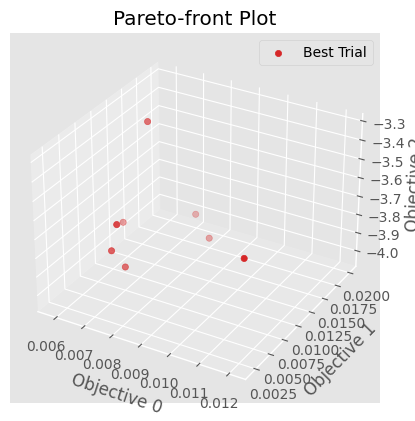

In [38]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [41]:
joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/nf_fwhm_pl_pi/trials.joblib']

In [46]:
opt_trial.initial_motor_positions

[-174.8,
 -165.6,
 0.17247733853924987,
 0.0106,
 416.8,
 0.17155733853924987,
 0.0029]

In [47]:
opt_trial.study.trials[0].params

{'hb_1': 0.0,
 'hb_2': 0.0,
 'hb_pitch': 0.0,
 'hb_trans': 0.0,
 'vb_bender': 0.0,
 'vb_pitch': 0.0,
 'vb_trans': 0.0}

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.026785665319488748, 0.06841908146603776, -2.9931922995318843]
Absolute motor values
{'hb_1': [-174.80000000000007], 'hb_2': [-165.6], 'hb_pitch': [0.17247733853924987], 'hb_trans': [0.01055823096934741], 'vb_bender': [416.8], 'vb_pitch': [0.17155733853924987], 'vb_trans': [0.0035833376928865856]}


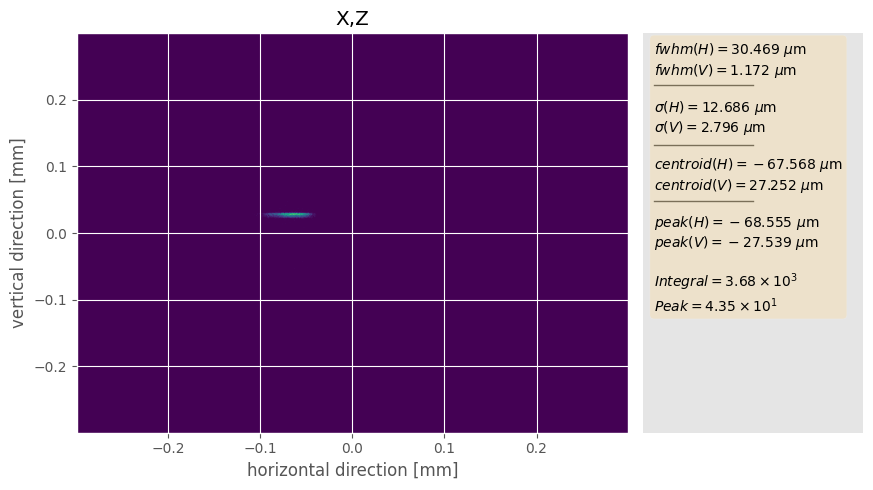

In [45]:
t = opt_trial.study.trials[0]

params = t.params
current_params = []
for mot in opt_trial.motor_types:
    current_params.append(params[mot])

opt_trial._loss_fn_this(current_params)
print(t.values)



print("Absolute motor values")
abs_motor_values = {mt: movers.get_absolute_positions(opt_trial.focusing_system, mt) for mt in opt_trial.motor_types}
print(abs_motor_values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

Trial number 43
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.00442263582511622, 0.015936177546666857, -4.059900403128302]
Absolute motor values
{'hb_1': [-174.80000000000007], 'hb_2': [-160.6], 'hb_pitch': [0.17186733853924988], 'hb_trans': [0.0063395727661486635], 'vb_bender': [418.8], 'vb_pitch': [0.17181733853924988], 'vb_trans': [0.011380109471839522]}


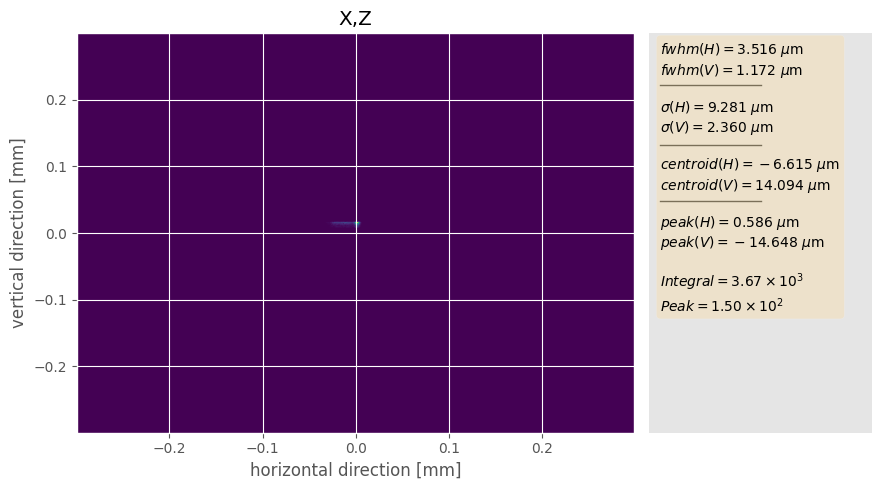

Trial number 52
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.005382393298830067, 0.005252132255248668, -4.288446149654159]
Absolute motor values
{'hb_1': [-169.80000000000007], 'hb_2': [-162.6], 'hb_pitch': [0.17186733853924988], 'hb_trans': [-0.004060427233851336], 'vb_bender': [418.8], 'vb_pitch': [0.17179733853924986], 'vb_trans': [-0.003319188532488058]}


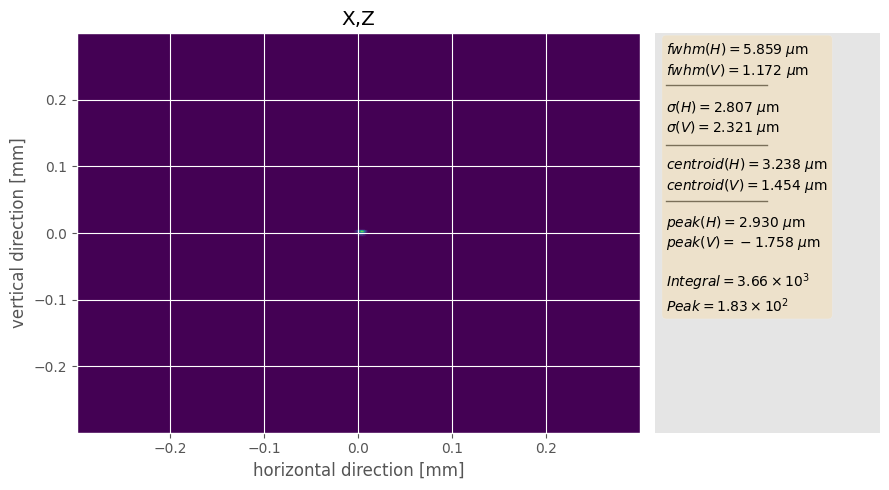

Trial number 138
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.0057200519351335265, 0.0017613573739843774, -4.254980021263275]
Absolute motor values
{'hb_1': [-169.80000000000007], 'hb_2': [-160.6], 'hb_pitch': [0.17189733853924988], 'hb_trans': [0.0021392131369644624], 'vb_bender': [419.8], 'vb_pitch': [0.17183733853924987], 'vb_trans': [-0.003618881460583409]}


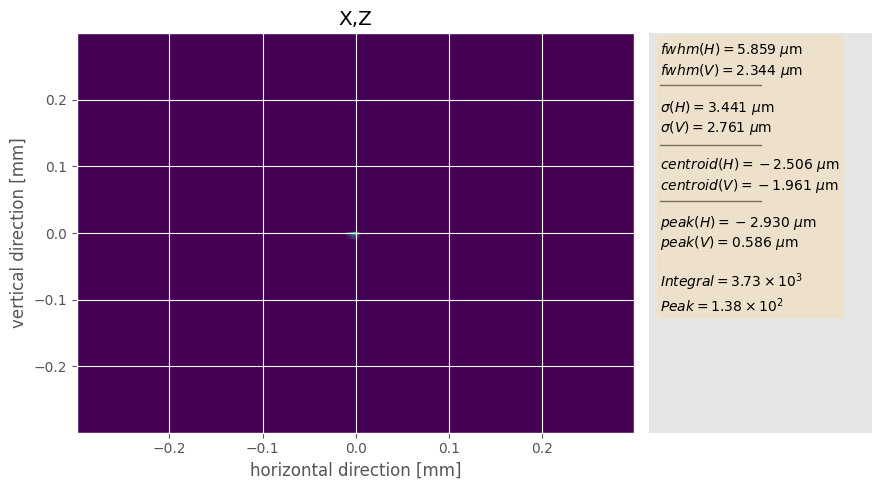

In [48]:
for t in opt_trial.study.best_trials:
    print("Trial number", t.number)
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    
    
    
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    print("Absolute motor values")
    abs_motor_values = {mt: movers.get_absolute_positions(opt_trial.focusing_system, mt) for mt in opt_trial.motor_types}
    print(abs_motor_values)
    
    opt_common.plot_distribution(
        photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    #plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    #print(vals)
    #plt.figure(figsize=[5, 5])
    #plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    #plt.axis("off")
    #plt.show()

### This is the analysis part

In [67]:
hist_dir = Path(save_dir)
hist_dir.exists()

True

In [68]:
trials_file = save_dir / "trials.joblib"

In [69]:
study = analysis.create_study_from_trials(trials_file, n_objectives=3)
n_steps = len(study.trials)

[I 2023-08-07 23:54:10,651] A new study created in memory with name: no-name-77719a75-4357-437b-9d99-4e335dd9f5d0


Assuming minimization for all objectives.


In [70]:
hist_dir

PosixPath('/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/nf_fwhm_pl_pi')

In [71]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

In [72]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

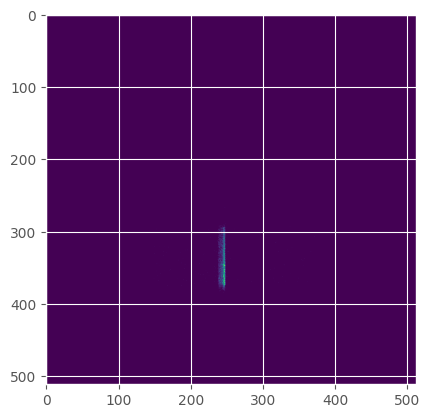

In [73]:
plt.imshow(hists[0].data_2D)

Trial number 19
Trial values: peak_distance 4.206e-03 fwhm 5.720e-03 int -5.105e+00
Trial dw:
{'h_sigma': 0.002539848958215076, 'h_fwhm': 0.005484374999999986, 'h_centroid': -0.0028875819228610577, 'h_peak': -0.003427734374999991, 'v_sigma': 0.005205385797780787, 'v_fwhm': 0.0016249999999999876, 'v_centroid': -0.006155236559692996, 'v_peak': 0.0024374999999999813, 'integral_intensity': 3673.731436128989, 'peak_intensity': 164.91681681248994, 'gaussian_fit': {}}
Actual fwhm 0.0057200519351335265


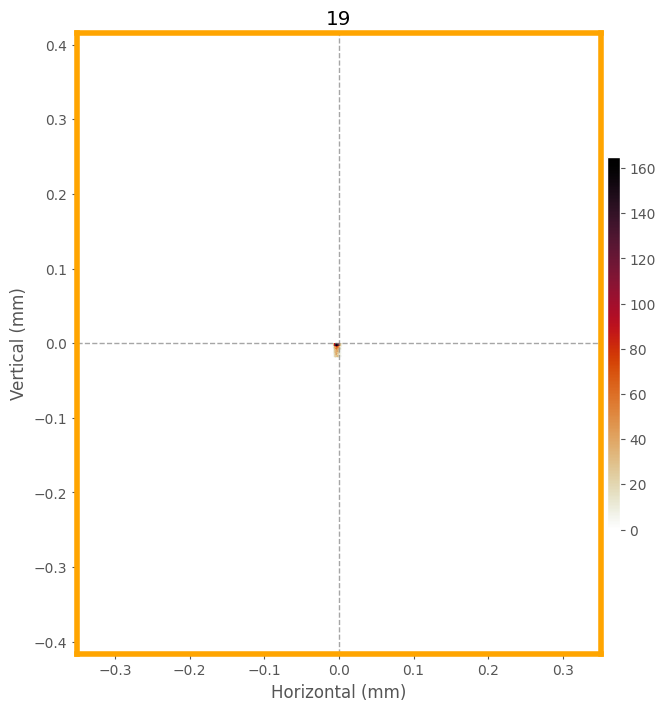

Trial number 31
Trial values: peak_distance 1.063e-03 fwhm 2.320e-02 int -3.197e+00
Trial dw:
{'h_sigma': 0.007725176817970884, 'h_fwhm': 0.009597656249999975, 'h_centroid': -0.002161917506224668, 'h_peak': -0.0006855468749999982, 'v_sigma': 0.012310903662252234, 'v_fwhm': 0.02112499999999984, 'v_centroid': -0.01122080679517563, 'v_peak': 0.0008124999999999938, 'integral_intensity': 3713.7797273034107, 'peak_intensity': 24.449729665414065, 'gaussian_fit': {}}
Actual fwhm 0.023203030631647168


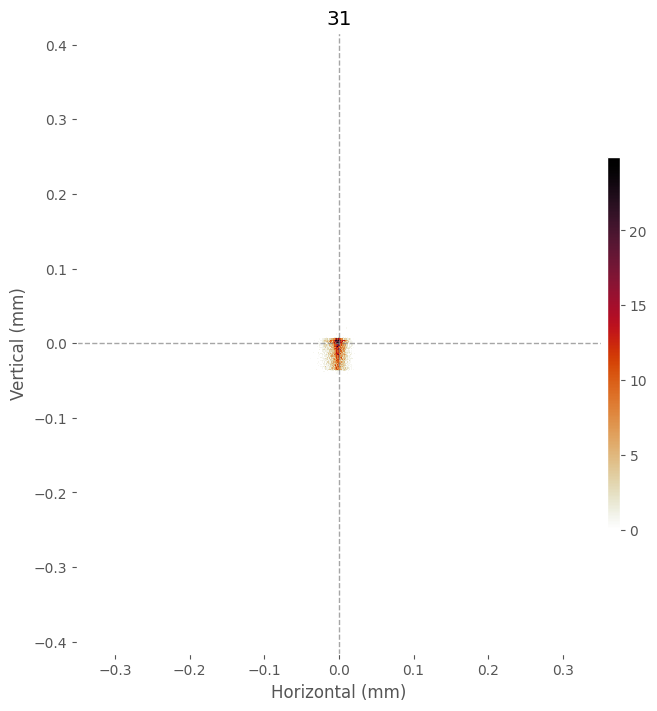

Trial number 52
Trial values: peak_distance 3.189e-03 fwhm 5.720e-03 int -4.805e+00
Trial dw:
{'h_sigma': 0.019710959557850197, 'h_fwhm': 0.005484374999999986, 'h_centroid': -0.003095033023306437, 'h_peak': 0.0020566406249999947, 'v_sigma': 0.0023555013735964544, 'v_fwhm': 0.0016249999999999876, 'v_centroid': -0.003983880423393242, 'v_peak': 0.0024374999999999813, 'integral_intensity': 3611.963419352089, 'peak_intensity': 122.06413536400127, 'gaussian_fit': {}}
Actual fwhm 0.0057200519351335265


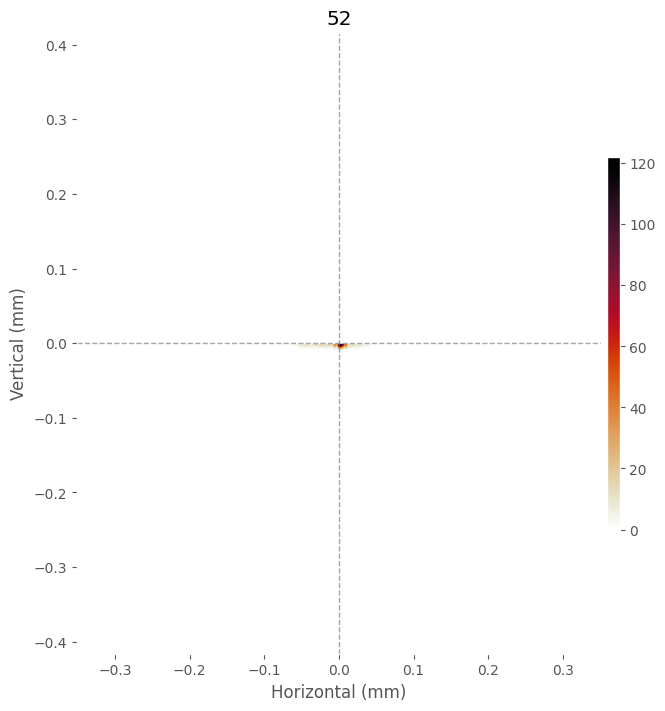

Trial number 53
Trial values: peak_distance 1.615e-02 fwhm 4.423e-03 int -5.065e+00
Trial dw:
{'h_sigma': 0.010179348874463595, 'h_fwhm': 0.004113281249999989, 'h_centroid': 0.01837329793701225, 'h_peak': 0.014396484375000018, 'v_sigma': 0.0031476971999844744, 'v_fwhm': 0.0016249999999999876, 'v_centroid': 0.00469699480806764, 'v_peak': -0.0073124999999999996, 'integral_intensity': 3630.681312207144, 'peak_intensity': 158.39984564357346, 'gaussian_fit': {}}
Actual fwhm 0.00442263582511622


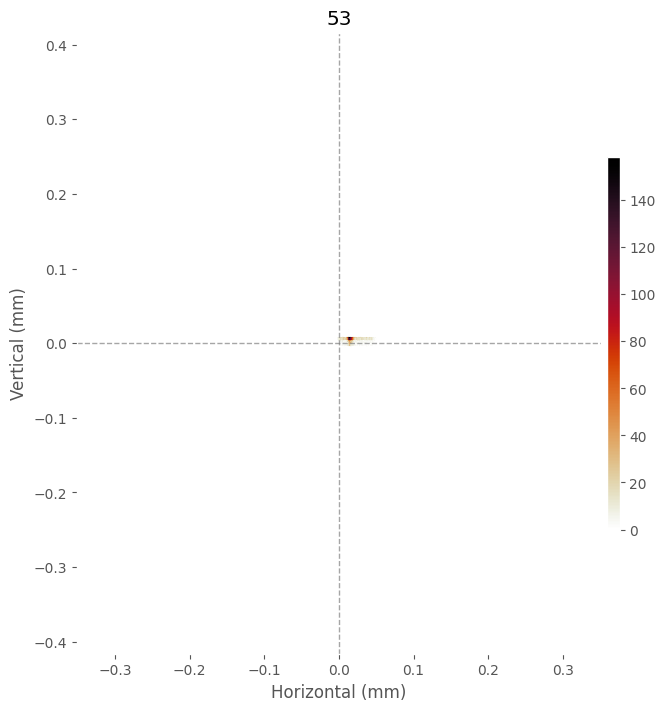

Trial number 57
Trial values: peak_distance 6.223e-03 fwhm 5.720e-03 int -5.281e+00
Trial dw:
{'h_sigma': 0.010956971198830648, 'h_fwhm': 0.005484374999999986, 'h_centroid': 0.013676851891349867, 'h_peak': 0.006169921874999984, 'v_sigma': 0.0025057994901159565, 'v_fwhm': 0.0016249999999999876, 'v_centroid': -0.0007047843773862442, 'v_peak': -0.0008124999999999938, 'integral_intensity': 3650.501748618189, 'peak_intensity': 196.537724592788, 'gaussian_fit': {}}
Actual fwhm 0.0057200519351335265


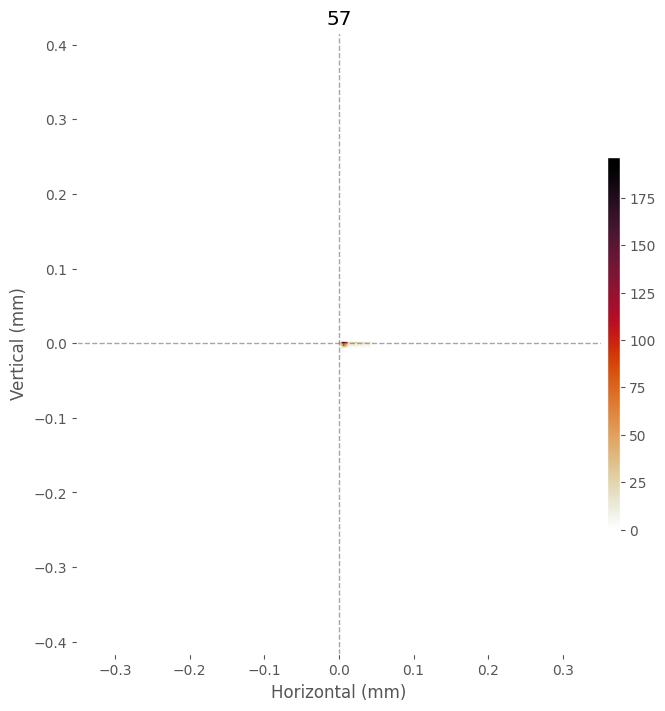

Trial number 121
Trial values: peak_distance 2.211e-03 fwhm 7.045e-03 int -5.207e+00
Trial dw:
{'h_sigma': 0.0099794338555909, 'h_fwhm': 0.006855468749999982, 'h_centroid': 0.006208246530678106, 'h_peak': -0.0020566406249999947, 'v_sigma': 0.0021237999393647995, 'v_fwhm': 0.0016249999999999876, 'v_centroid': -0.00038231660217749304, 'v_peak': -0.0008124999999999938, 'integral_intensity': 3677.0140694300694, 'peak_intensity': 182.54514709394488, 'gaussian_fit': {}}
Actual fwhm 0.0070454294959375096


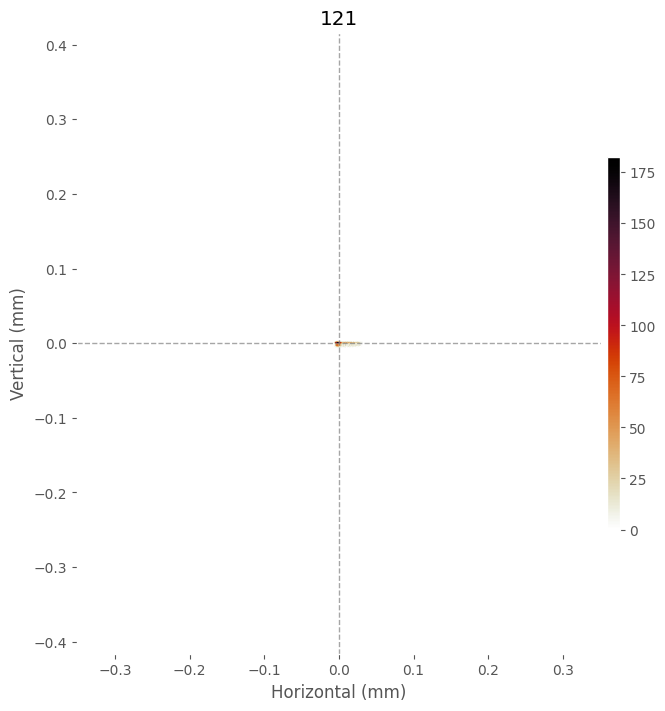

Trial number 130
Trial values: peak_distance 2.211e-03 fwhm 5.720e-03 int -4.723e+00
Trial dw:
{'h_sigma': 0.026414695543703053, 'h_fwhm': 0.005484374999999986, 'h_centroid': -0.0034803658049668146, 'h_peak': -0.0020566406249999947, 'v_sigma': 0.002267470640777782, 'v_fwhm': 0.0016249999999999876, 'v_centroid': -0.0009355182407406558, 'v_peak': -0.0008124999999999938, 'integral_intensity': 3686.948993405012, 'peak_intensity': 112.51821846295687, 'gaussian_fit': {}}
Actual fwhm 0.0057200519351335265


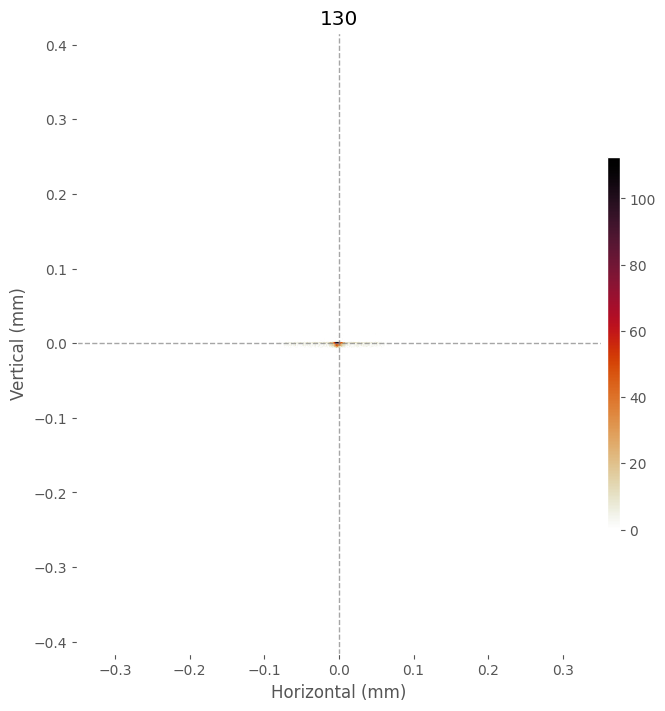

Trial number 136
Trial values: peak_distance 5.729e-03 fwhm 5.720e-03 int -5.208e+00
Trial dw:
{'h_sigma': 0.012021791492404947, 'h_fwhm': 0.005484374999999986, 'h_centroid': 0.009800385074922912, 'h_peak': 0.0006855468749999982, 'v_sigma': 0.001870525745496553, 'v_fwhm': 0.0016249999999999876, 'v_centroid': 0.004302811563550732, 'v_peak': -0.005687500000000012, 'integral_intensity': 3657.6445513677086, 'peak_intensity': 182.73292324660724, 'gaussian_fit': {}}
Actual fwhm 0.0057200519351335265


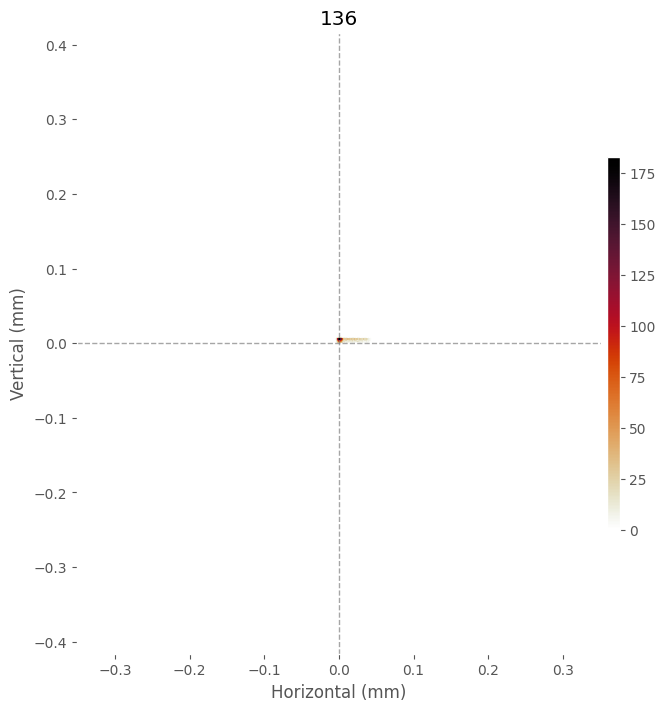

In [122]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e} int {t.values[2]:4.3e}")
    print("Trial dw:")
    
    dw = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dw)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.figure(figsize=[7,7], constrained_layout=True)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2)#, norm=mpl.colors.LogNorm(1, 4e2))
    #plt.xlim(-0.04,0.04)
    #plt.ylim(-0.04,0.04)
    plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect('equal')
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
            ax.spines[axis].set_color('orange')

    plt.title(t.number)
    plt.show()

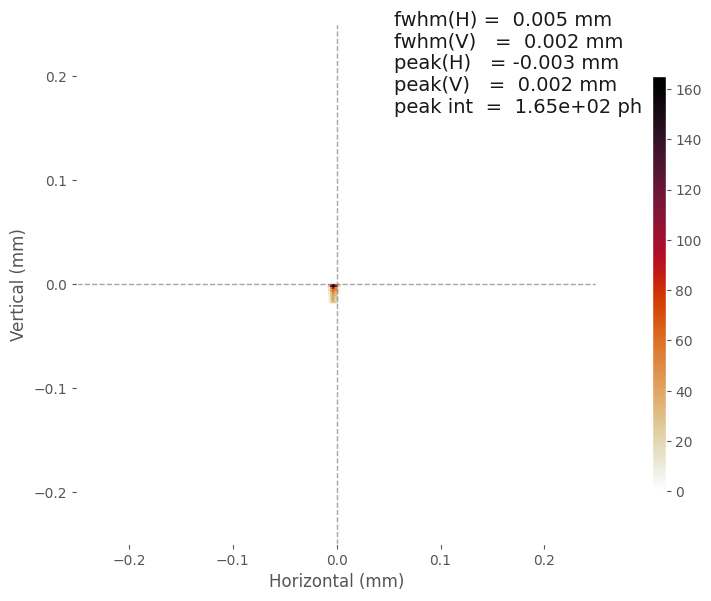

In [123]:

tnum = nash_trial.number
dw = dict(**study.trials[tnum].user_attrs["dw"]._DictionaryWrapper__dictionary)
hist = hists[tnum]
plt.figure(figsize=[7,7], constrained_layout=True)
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2, )#norm=mpl.colors.LogNorm(0.3, 4e2))
plt.xlim(-0.25,0.25)
plt.ylim(-0.25,0.25)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (f"{'fwhm(H)':<6} = {dw['h_fwhm']: 4.3f} mm\n"
             f"{'fwhm(V)':<9} = {dw['v_fwhm']: 4.3f} mm\n"
             f"{'peak(H)':<9} = {dw['h_peak']: 4.3f} mm\n"
             f"{'peak(V)':<9} = {dw['v_peak']: 4.3f} mm\n"
             f"{'peak int':<9} = {dw['peak_intensity']: 3.2e} ph")
ax.text(0.055, 0.165, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.7))
plt.show()

In [101]:
[t.values for t in study.trials]

[[0.0905505300842304, 0.1384854709014175, -2.9333957863556175],
 [0.23724930980007097, 0.20536526580421102, -2.151751135518224],
 [0.10518781594621628, 0.0964049130537172, -1.0895600053149403],
 [0.0734640428470324, 0.24722317511337982, -1.7066775964218301],
 [0.026252727548491946, 0.16394893289621876, -3.687334114270199],
 [0.07859467724353582, 0.2738488235604378, -1.7014209532588682],
 [0.06863168130115006, 0.21160312435425124, -2.2623689223479735],
 [0.020630503896900746, 0.07472902650574502, -3.9260396475251067],
 [0.024131942461655485, 0.10315828477481528, -2.9085673918925985],
 [0.09873212357972683, 0.2941276663980755, -2.6358411952787946],
 [0.02742187499999993, 0.0758868015167308, -3.8552343732284724],
 [0.05493996190445061, 0.060151162306415554, -2.992912246331027],
 [0.013710937499999964, 0.03921365641918592, -4.459796371063467],
 [0.28115509013290224, 0.08966721057608708, -1.886836605420869],
 [0.015428226295526495, 0.0479815972734381, -3.8733287026959813],
 [0.0590465412519

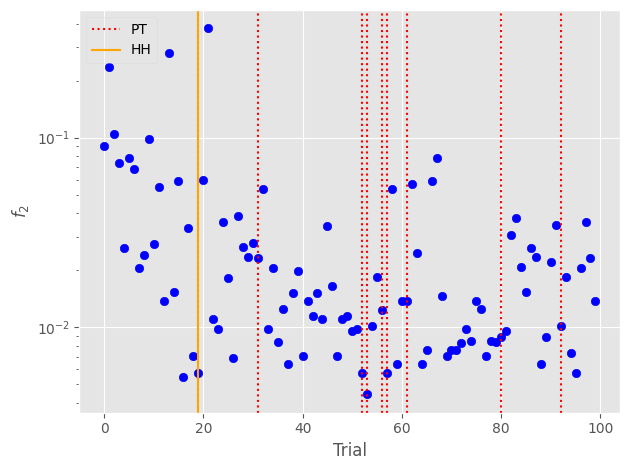

In [102]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = [t.number for t in study.trials if t.values is not None]
y = [t.values[0] for t in study.trials if t.values is not None]
plt.scatter(x,y, color='blue')
plt.xlabel('Trial')
plt.ylabel('$f_2$')
plt.yscale('log')
for t in study.best_trials[:-1]:
    plt.axvline(t.number, color='red', ls=':')
plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
plt.axvline(nash_trial.number, color='orange', label='HH')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

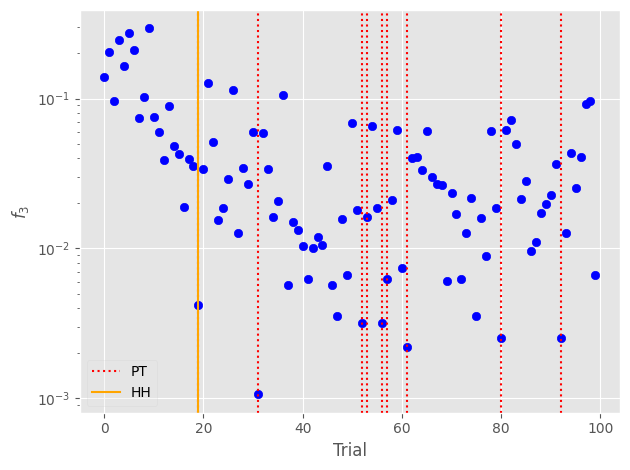

In [103]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = [t.number for t in study.trials if t.values is not None]
y = [t.values[1] for t in study.trials if t.values is not None]
plt.scatter(x,y, color='blue')
plt.xlabel('Trial')
plt.ylabel('$f_3$')
plt.yscale('log')
for t in study.best_trials[:-1]:
    plt.axvline(t.number, color='red', ls=':')
plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
plt.axvline(nash_trial.number, color='orange', label='HH')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

In [104]:
attribs_init

{'fwhm': 0.0905505300842304,
 'peak_distance': 0.1384854709014175,
 'negative_log_peak_intensity': -2.9333957863556175}

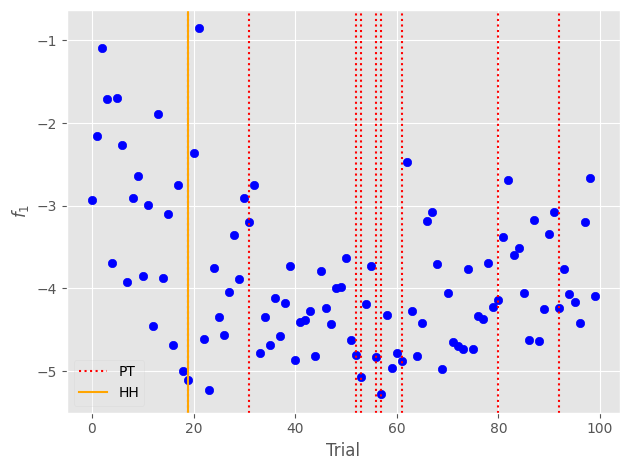

In [105]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = [t.number for t in study.trials if t.values is not None]
y = [t.values[2] for t in study.trials if t.values is not None]
plt.scatter(x,y, color='blue')
plt.xlabel('Trial')
plt.ylabel('$f_1$')
#plt.yscale('symlog')
for t in study.best_trials[:-1]:
    plt.axvline(t.number, color='red', ls=':')
plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
plt.axvline(nash_trial.number, color='orange', label='HH')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

In [106]:
attribs_focus

{'fwhm': 0.005242287920517273,
 'peak_distance': 0.001063076087503737,
 'negative_log_peak_intensity': -5.726095206772236}

In [107]:
attribs_focus

{'fwhm': 0.005242287920517273,
 'peak_distance': 0.001063076087503737,
 'negative_log_peak_intensity': -5.726095206772236}

In [108]:
colors = []
c_this = 0
for ix in range(ints_flat.size):
    if ix < 80: 
        c_this = 0
    else:
        c_this = (ix - 80) // 50 + 1
    colors.append(c_this)

optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[0], t.values[1]], 
                                                  target_names=['fwhm', 'peak_location'])
plt.scatter(attribs_focus['fwhm'], attribs_focus['peak_distance'], color='green', label='True')
plt.yscale('log')
plt.xscale('log')

NameError: name 'ints_flat' is not defined

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_75782/3908915646.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[1], t.values[2]],


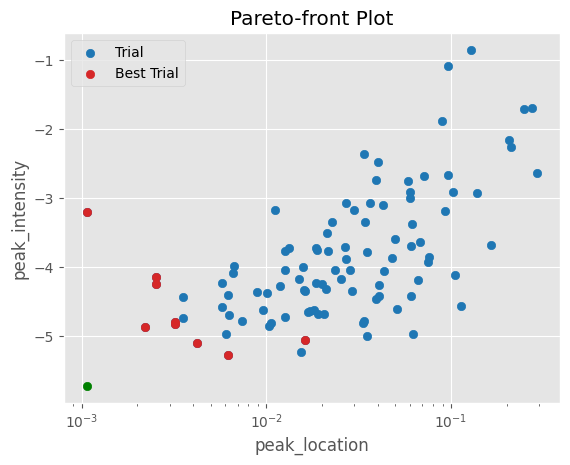

In [109]:
optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[1], t.values[2]],
                                                 target_names=['peak_location', 'peak_intensity'])

plt.scatter(attribs_focus['peak_distance'], attribs_focus['negative_log_peak_intensity'], color='green', label='True')
plt.xscale('log')

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_75782/2296441054.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[0], t.values[2]],


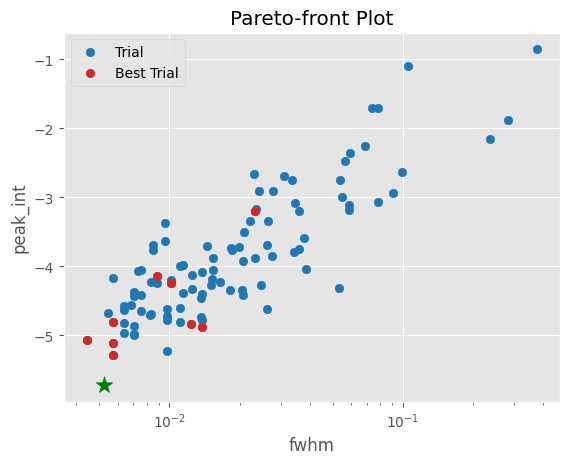

In [110]:
optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[0], t.values[2]],
                                                 target_names=['fwhm', 'peak_int'])
plt.scatter(attribs_focus['fwhm'], attribs_focus['negative_log_peak_intensity'], color='green', label='True', s=155, marker='*')
plt.xscale('log')